# Predictions Visualization, Summary Statistics, and Grad-CAM Heatmaps

### Import Libraries

In [1]:
from pathlib import Path

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

import networks

# Set the style for seaborn
sns.set_style("white")

### Define Paths

In [2]:
# Define paths to workspace, predictions, and test set images
workspace = Path("../")
test_set_predictions_path = workspace / "results" / "test_set_predictions"
test_set_images_path = workspace / "data" / "test_set" / "images"

### Load Predictions and Initialize Models

In [3]:
predictions = pd.read_csv(test_set_predictions_path / "predictions.csv")

In [4]:
# 3D CNN model definition for malignancy prediction
malignancy_model = networks.CNN3D(
    n_input_channels=1,
    n_output_channels=1,  # Set output channels to 1 for malignancy prediction
    task="malignancy",
)

# 3D CNN model definition for nodule type prediction
noduletype_model = networks.CNN3D(
    n_input_channels=1,
    n_output_channels=4,  # Set output channels to 4 for nodule type prediction
    task="noduletype",
)

# U-Net definition model for segmentation
segmentation_model = networks.UNet(
    n_input_channels=1,
    n_filters=64,
    n_output_channels=1,
    sigmoid=True,
)

# Load the ViT model
vit_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True)
vit_model.head = nn.Linear(vit_model.head.in_features, 4)  # Adjust output for 4 classes

# Define the 3D CNN model for malignancy prediction trained with balanced dataset
malignancy_model_bal = networks.CNN3D(
    n_input_channels=1,
    n_output_channels=1,  # Set output channels to 1 for malignancy prediction
    task="malignancy",
)

# Define the 3D CNN model for nodule type prediction trained with balanced dataset
noduletype_model_bal = networks.CNN3D(
    n_input_channels=1,
    n_output_channels=4,  # Set output channels to 4 for nodule type prediction
    task="noduletype",
)

### Load Model State Dictionaries

In [5]:
# Baseline - Malignancy Classification model (3-CNN)
malignancy_model.load_state_dict(
    torch.load('../results/20240526_0_malignancy_ORIGINAL/fold0/best_model.pth', map_location=torch.device('cpu')))
malignancy_model.eval()

# Baseline - Nodule Type Classification model (3D-CNN)
noduletype_model.load_state_dict(
    torch.load('../results/20240526_0_noduletype_ORIGINAL/fold0/best_model.pth', map_location=torch.device('cpu')))
noduletype_model.eval()

# Baseline - Segmentation model (U-Net)
segmentation_model.load_state_dict(
    torch.load('../results/20240526_0_segmentation_ORIGINAL/fold0/best_model.pth', map_location=torch.device('cpu')))
segmentation_model.eval()

# Third Approach - Nodule Type Classification model (ViT)
vit_model.load_state_dict(torch.load('../results/ViT_noduletype_ORIGINAL/20240522_0_noduletype/fold0/best_model.pth',
                                     map_location=torch.device('cpu')))
vit_model.eval()

# Fourth Approach - Malignancy Classification model (3D-CNN trained with balanced dataset)
malignancy_model_bal.load_state_dict(
    torch.load('../results/20240527_0_malignancy_BALANCED_DATASET_ME/fold0/best_model.pth',
               map_location=torch.device('cpu')))
malignancy_model.eval()

# Fourth Approach - Nodule Type Classification model (3D CNN trained with balanced dataset)
noduletype_model_bal.load_state_dict(
    torch.load('../results/20240525_0_noduletype_BALANCED_DATASET/fold0/best_model.pth',
               map_location=torch.device('cpu')))
noduletype_model.eval()

CNN3D(
  (classification): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (13): BatchNorm3d(128, eps=1e-05, moment

### Preprocess Image Function
#### Function to preprocess the image for the model 

In [6]:
# Function to preprocess the image for the model
def preprocess_image(image_array):
    image_array = image_array.astype(np.float32)  # Ensure the image array is in float format
    image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
    image_tensor = F.interpolate(image_tensor, size=(64, 64, 64), mode='trilinear',
                                 align_corners=False)  # Resize if needed
    return image_tensor

#### Function to preprocess the image for the ViT model

In [7]:
# Function to preprocess the image for ViT
def preprocess_image_vit(image_array):
    image_array = image_array.astype(np.float32)
    image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
    image_tensor = F.interpolate(image_tensor, size=(224, 224, 224), mode='trilinear',
                                 align_corners=False)  # Resize if needed
    image_tensor = image_tensor[:, :, image_tensor.shape[2] // 2, :, :]  # Take central slice
    image_tensor = image_tensor.repeat(1, 3, 1, 1)  # Convert to 3 channels
    return image_tensor

### Grad-CAM Function
#### Function to generate Grad-CAM heatmap (General version)

In [8]:
def make_gradcam_heatmap(model, image_tensor, target_layer, task):
    def hook_function(module, grad_in, grad_out):
        target_layer.activations = grad_out
        target_layer.activations.retain_grad()  # Retain gradients

    # Register the hook
    hook_handle = target_layer.register_forward_hook(hook_function)

    # Forward pass
    output = model(image_tensor)
    model.zero_grad()

    if task == "malignancy":
        class_idx = torch.argmax(output['malignancy']).item()
        class_output = output['malignancy'][0, class_idx]
    elif task == "noduletype":
        class_idx = torch.argmax(output['noduletype']).item()
        class_output = output['noduletype'][0, class_idx]
    else:  # segmentation
        class_output = output['segmentation'].sum()

    # Backward pass
    class_output.backward()

    # Get gradients and activations
    gradients = target_layer.activations.grad
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3, 4])
    activations = target_layer.activations[0]

    # Weight the activations
    for i in range(pooled_gradients.size(0)):
        activations[i, :, :, :] *= pooled_gradients[i]

    # Generate heatmap
    heatmap = torch.mean(activations, dim=0).detach().numpy()
    max_heatmap = np.maximum(heatmap, 0)  # Apply ReLU to the heatmap

    # Normalize the heatmap
    if np.max(max_heatmap) != 0:
        heatmap = max_heatmap / np.max(max_heatmap)

    # Remove the hook
    hook_handle.remove()

    return heatmap

#### Function to generate Grad-CAM heatmap for Vision Transformer (ViT)

In [9]:
def make_gradcam_heatmap_vit(model, image_tensor, target_layer):
    gradients = []
    activations = []

    def hook_function(module, grad_in, grad_out):
        activations.append(grad_out[:, 1:, :])  # Remove the class token activations
        grad_out.register_hook(lambda grad: gradients.append(grad[:, 1:, :]))  # Remove the class token gradients

    handle = target_layer.register_forward_hook(hook_function)
    model.eval()  # Ensure the model is in evaluation mode

    output = model(image_tensor)

    model.zero_grad()

    class_idx = torch.argmax(output).item()
    class_output = output[0, class_idx]

    class_output.backward(retain_graph=True)

    # Ensure the hook is properly removed
    handle.remove()

    # Check if gradients and activations were captured
    if len(gradients) == 0 or len(activations) == 0:
        raise ValueError("Gradients or activations are None, ensure the backward pass is correct.")

    gradients = gradients[0]
    activations = activations[0]

    # Mean pooling of gradients
    pooled_gradients = torch.mean(gradients, dim=1).squeeze()

    # Weights for each channel
    for i in range(pooled_gradients.size(0)):
        activations[:, :, i] *= pooled_gradients[i]

    # Average the channels
    heatmap = torch.mean(activations, dim=2).squeeze().detach().numpy()

    # Apply ReLU to the heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    max_heatmap = np.max(heatmap)
    if max_heatmap != 0:
        heatmap /= max_heatmap

    return heatmap

### Visualization Functions
#### Function to create visualizations for original models

In [10]:
def create_visualization_original(image_path, prediction, idx, malignancy_model, noduletype_model, segmentation_model,
                                  malignancy_layer, noduletype_layer, segmentation_layer):
    noduleid = image_path.stem

    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)

    image_tensor = preprocess_image(image_array)

    # Generate Grad-CAM heatmaps
    malignancy_heatmap = make_gradcam_heatmap(malignancy_model, image_tensor, malignancy_layer, task="malignancy")
    noduletype_heatmap = make_gradcam_heatmap(noduletype_model, image_tensor, noduletype_layer, task="noduletype")
    segmentation_heatmap = make_gradcam_heatmap(segmentation_model, image_tensor, segmentation_layer,
                                                task="segmentation")

    # Resize heatmaps to image size
    malignancy_heatmap_rescaled = F.interpolate(torch.tensor(malignancy_heatmap).unsqueeze(0).unsqueeze(0),
                                                size=image_array.shape, mode='trilinear',
                                                align_corners=False).squeeze().numpy()
    noduletype_heatmap_rescaled = F.interpolate(torch.tensor(noduletype_heatmap).unsqueeze(0).unsqueeze(0),
                                                size=image_array.shape, mode='trilinear',
                                                align_corners=False).squeeze().numpy()
    segmentation_heatmap_rescaled = F.interpolate(torch.tensor(segmentation_heatmap).unsqueeze(0).unsqueeze(0),
                                                  size=image_array.shape, mode='trilinear',
                                                  align_corners=False).squeeze().numpy()

    segmentation = sitk.ReadImage(str(test_set_predictions_path / "segmentations" / f"{noduleid}.mha"))
    segmentation_array = sitk.GetArrayFromImage(segmentation)

    fig, axes = plt.subplots(1, 5, figsize=(30, 6), constrained_layout=True)

    # Original Image
    axes[0].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[0].set_title(f"Original Image: {noduleid}", fontsize=14)
    axes[0].axis("off")

    # Segmentation Overlay
    axes[1].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[1].imshow(segmentation_array[32], vmin=0, vmax=1, cmap="jet", alpha=0.5)
    axes[1].set_title(f"Segmentation\nMalignancy: {prediction.malignancy:.2f}, Type: {prediction.noduletype}",
                      fontsize=14)
    axes[1].axis("off")

    # Grad-CAM Heatmap for Malignancy
    axes[2].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[2].imshow(malignancy_heatmap_rescaled[32], cmap='jet', alpha=0.5)
    axes[2].set_title("Malignancy Grad-CAM Heatmap", fontsize=14)
    axes[2].axis("off")

    # Grad-CAM Heatmap for Noduletype
    axes[3].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[3].imshow(noduletype_heatmap_rescaled[32], cmap='jet', alpha=0.5)
    axes[3].set_title("Noduletype Grad-CAM Heatmap", fontsize=14)
    axes[3].axis("off")

    # Grad-CAM Heatmap for Segmentation
    axes[4].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[4].imshow(segmentation_heatmap_rescaled[32], cmap='jet', alpha=0.5)
    axes[4].set_title("Segmentation Grad-CAM Heatmap", fontsize=14)
    axes[4].axis("off")

    # fig.savefig(test_set_predictions_path / "figures" / f"{noduleid}_visualization_original.png", dpi=300)

    plt.show()

#### Function to create visualizations for Vision Transformer (ViT)

In [11]:
def create_visualization_vit(image_path, prediction, idx, vit_model, vit_layer):
    noduleid = image_path.stem

    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)

    image_tensor_vit = preprocess_image_vit(image_array)

    # Generate Grad-CAM heatmap for ViT
    vit_heatmap = make_gradcam_heatmap_vit(vit_model, image_tensor_vit, vit_layer)

    # Reshape the heatmap to match the patch dimensions (14x14 for ViT base)
    heatmap_shape = int(np.sqrt(vit_heatmap.shape[0]))
    vit_heatmap = vit_heatmap.reshape((heatmap_shape, heatmap_shape))

    # Resize heatmap to image size
    vit_heatmap_rescaled = F.interpolate(torch.tensor(vit_heatmap).unsqueeze(0).unsqueeze(0),
                                         size=(image_array.shape[1], image_array.shape[2]), mode='bilinear',
                                         align_corners=False).squeeze().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

    # Original Image
    axes[0].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[0].set_title(f"Original Image: {noduleid}", fontsize=14)
    axes[0].axis("off")

    # Grad-CAM Heatmap for Noduletype (ViT Model)
    axes[1].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[1].imshow(vit_heatmap_rescaled, cmap='jet', alpha=0.5)
    axes[1].set_title("Noduletype Grad-CAM Heatmap (ViT)", fontsize=14)
    axes[1].axis("off")

    # fig.savefig(test_set_predictions_path / "figures" / f"{noduleid}_visualization_vit.png", dpi=300)

    plt.show()

#### Function to create visualizations for comparison - Original and ViT models for nodule type

In [12]:
def create_visualization_vit_cnn(image_path, prediction, idx, vit_model, vit_layer, cnn_model, cnn_layer):
    noduleid = image_path.stem

    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)

    image_tensor_vit = preprocess_image_vit(image_array)
    image_tensor_cnn = preprocess_image(image_array)

    # Generate Grad-CAM heatmap for ViT
    vit_heatmap = make_gradcam_heatmap_vit(vit_model, image_tensor_vit, vit_layer)

    # Reshape the heatmap to match the patch dimensions (14x14 for ViT base)
    heatmap_shape = int(np.sqrt(vit_heatmap.shape[0]))
    vit_heatmap = vit_heatmap.reshape((heatmap_shape, heatmap_shape))

    # Resize heatmap to image size
    vit_heatmap_rescaled = F.interpolate(torch.tensor(vit_heatmap).unsqueeze(0).unsqueeze(0),
                                         size=(image_array.shape[1], image_array.shape[2]), mode='bilinear',
                                         align_corners=False).squeeze().numpy()

    # Generate Grad-CAM heatmap for 3D CNN Noduletype
    cnn_heatmap = make_gradcam_heatmap(cnn_model, image_tensor_cnn, cnn_layer, task="noduletype")

    # Resize 3D CNN heatmap to image size
    cnn_heatmap_rescaled = F.interpolate(torch.tensor(cnn_heatmap).unsqueeze(0).unsqueeze(0), size=image_array.shape,
                                         mode='trilinear', align_corners=False).squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

    # Original Image
    axes[0].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[0].set_title(f"Original Image: {noduleid}", fontsize=14)
    axes[0].axis("off")

    # Grad-CAM Heatmap for Noduletype (ViT Model)
    axes[1].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[1].imshow(vit_heatmap_rescaled, cmap='jet', alpha=0.5)
    axes[1].set_title("Noduletype Grad-CAM Heatmap (ViT)", fontsize=14)
    axes[1].axis("off")

    # Grad-CAM Heatmap for Noduletype (3D CNN Model)
    axes[2].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[2].imshow(cnn_heatmap_rescaled[32], cmap='jet', alpha=0.5)
    axes[2].set_title("Noduletype Grad-CAM Heatmap (3D CNN)", fontsize=14)
    axes[2].axis("off")

    # fig.savefig(test_set_predictions_path / "figures" / f"{noduleid}_visualization_comparison.png", dpi=300)

    plt.show()

#### Function to create visualizations for comparison - Original and Balanced models for malignancy

In [13]:
def create_visualization_comparison_malignancy(image_path, prediction, idx, malignancy_model_original,
                                               malignancy_model_balanced, malignancy_layer):
    noduleid = image_path.stem

    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)

    image_tensor = preprocess_image(image_array)

    # Generate Grad-CAM heatmaps for original and balanced models
    malignancy_heatmap_original = make_gradcam_heatmap(malignancy_model_original, image_tensor, malignancy_layer,
                                                       task="malignancy")

    malignancy_heatmap_balanced = make_gradcam_heatmap(malignancy_model_balanced, image_tensor, malignancy_layer,
                                                       task="malignancy")

    # Resize heatmaps to image size
    malignancy_heatmap_original_rescaled = F.interpolate(
        torch.tensor(malignancy_heatmap_original).unsqueeze(0).unsqueeze(0), size=image_array.shape, mode='trilinear',
        align_corners=False).squeeze().numpy()
    malignancy_heatmap_balanced_rescaled = F.interpolate(
        torch.tensor(malignancy_heatmap_balanced).unsqueeze(0).unsqueeze(0), size=image_array.shape, mode='trilinear',
        align_corners=False).squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

    # Original Image
    axes[0].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[0].set_title(f"Original Image: {noduleid}", fontsize=14)
    axes[0].axis("off")

    # Grad-CAM Heatmap for Malignancy (Original Model)
    axes[1].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[1].imshow(malignancy_heatmap_original_rescaled[32], cmap='jet', alpha=0.5)
    axes[1].set_title("Malignancy Grad-CAM Heatmap (No Data Augmentation)", fontsize=14)
    axes[1].axis("off")

    # Grad-CAM Heatmap for Malignancy (Balanced Model)
    axes[2].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[2].imshow(malignancy_heatmap_balanced_rescaled[32], cmap='jet', alpha=0.5)
    axes[2].set_title("Malignancy Grad-CAM Heatmap (Data Augmentation)", fontsize=14)
    axes[2].axis("off")

    # fig.savefig(test_set_predictions_path / "figures" / f"{noduleid}_visualization_comparison_malignancy.png", dpi=300)

    plt.show()

#### Function to create visualizations for comparison - Original and Balanced models for nodule type

In [14]:
# Method for visualization that compares the heatmaps of the original models and the models trained with the balanced dataset for nodule type
def create_visualization_comparison_noduletype(image_path, prediction, idx, noduletype_model_original,
                                               noduletype_model_balanced, noduletype_layer):
    noduleid = image_path.stem

    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)

    image_tensor = preprocess_image(image_array)

    # Generate Grad-CAM heatmaps for original and balanced models
    noduletype_heatmap_original = make_gradcam_heatmap(noduletype_model_original, image_tensor, noduletype_layer,
                                                       task="noduletype")
    noduletype_heatmap_balanced = make_gradcam_heatmap(noduletype_model_balanced, image_tensor, noduletype_layer,
                                                       task="noduletype")

    # Resize heatmaps to image size
    noduletype_heatmap_original_rescaled = F.interpolate(
        torch.tensor(noduletype_heatmap_original).unsqueeze(0).unsqueeze(0), size=image_array.shape, mode='trilinear',
        align_corners=False).squeeze().numpy()
    noduletype_heatmap_balanced_rescaled = F.interpolate(
        torch.tensor(noduletype_heatmap_balanced).unsqueeze(0).unsqueeze(0), size=image_array.shape, mode='trilinear',
        align_corners=False).squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

    # Original Image
    axes[0].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[0].set_title(f"Original Image: {noduleid}", fontsize=14)
    axes[0].axis("off")

    # Grad-CAM Heatmap for Noduletype (Original Model)
    axes[1].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[1].imshow(noduletype_heatmap_original_rescaled[32], cmap='jet', alpha=0.5)
    axes[1].set_title("Noduletype Grad-CAM Heatmap (No Data Augmentation)", fontsize=14)
    axes[1].axis("off")

    # Grad-CAM Heatmap for Noduletype (Balanced Model)
    axes[2].imshow(image_array[32], vmin=-1500, vmax=500, cmap="gray")
    axes[2].imshow(noduletype_heatmap_balanced_rescaled[32], cmap='jet', alpha=0.5)
    axes[2].set_title("Noduletype Grad-CAM Heatmap (Data Augmentation)", fontsize=14)
    axes[2].axis("off")

    # fig.savefig(test_set_predictions_path / "figures" / f"{noduleid}_visualization_comparison_noduletype.png", dpi=300)

    plt.show()

### Create Output Directory

In [15]:
# Create output directory for figures
(test_set_predictions_path / "figures").mkdir(parents=True, exist_ok=True)

### Summary Statistics Function

In [16]:
# Print summary statistics for predictions
def print_summary_statistics(predictions):
    print("Summary Statistics for Predictions")
    print("---------------------------------")
    print(f"Total Number of Nodules: {len(predictions)}")
    print(f"Average Malignancy Probability: {predictions['malignancy'].mean():.4f}")
    print(f"Standard Deviation of Malignancy Probability: {predictions['malignancy'].std():.4f}")
    print(f"Nodule Type Distribution:\n{predictions['noduletype'].value_counts()}\n")

### Plot Distributions Function

In [17]:
# Function to plot both distributions side by side with consistent formatting
def plot_distributions(predictions):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    sns.set_style("whitegrid")
    palette = 'viridis'  # Using the same palette for both plots

    # Plot malignancy probability distribution
    sns.histplot(predictions['malignancy'], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title('Distribution of Malignancy Probabilities', fontsize=16)
    axes[0].set_xlabel('Malignancy Probability', fontsize=14)
    axes[0].set_ylabel('Frequency', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Plot nodule type distribution
    sns.countplot(data=predictions, x='noduletype', palette=palette, ax=axes[1])
    axes[1].set_title('Distribution of Nodule Types', fontsize=16)
    axes[1].set_xlabel('Nodule Type', fontsize=14)
    axes[1].set_ylabel('Frequency', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(0, max_y)
    axes[1].set_ylim(0, max_y)

    plt.tight_layout()
    plt.show()

### Target Layers for Grad-CAM and Iterate Over Test Set Images

In [18]:
# Target layers for Grad-CAM
malignancy_layer = malignancy_model.classification[6]  # Last Conv3d layer in malignancy model
noduletype_layer = noduletype_model.classification[6]  # Last Conv3d layer in noduletype model
vit_layer = vit_model.blocks[-1].norm1  # Last layer in ViT model
segmentation_layer = segmentation_model.contraction[-1]  # Last layer in contraction path of U-Net

## Baseline Models Results
### Grad-CAM Heatmaps

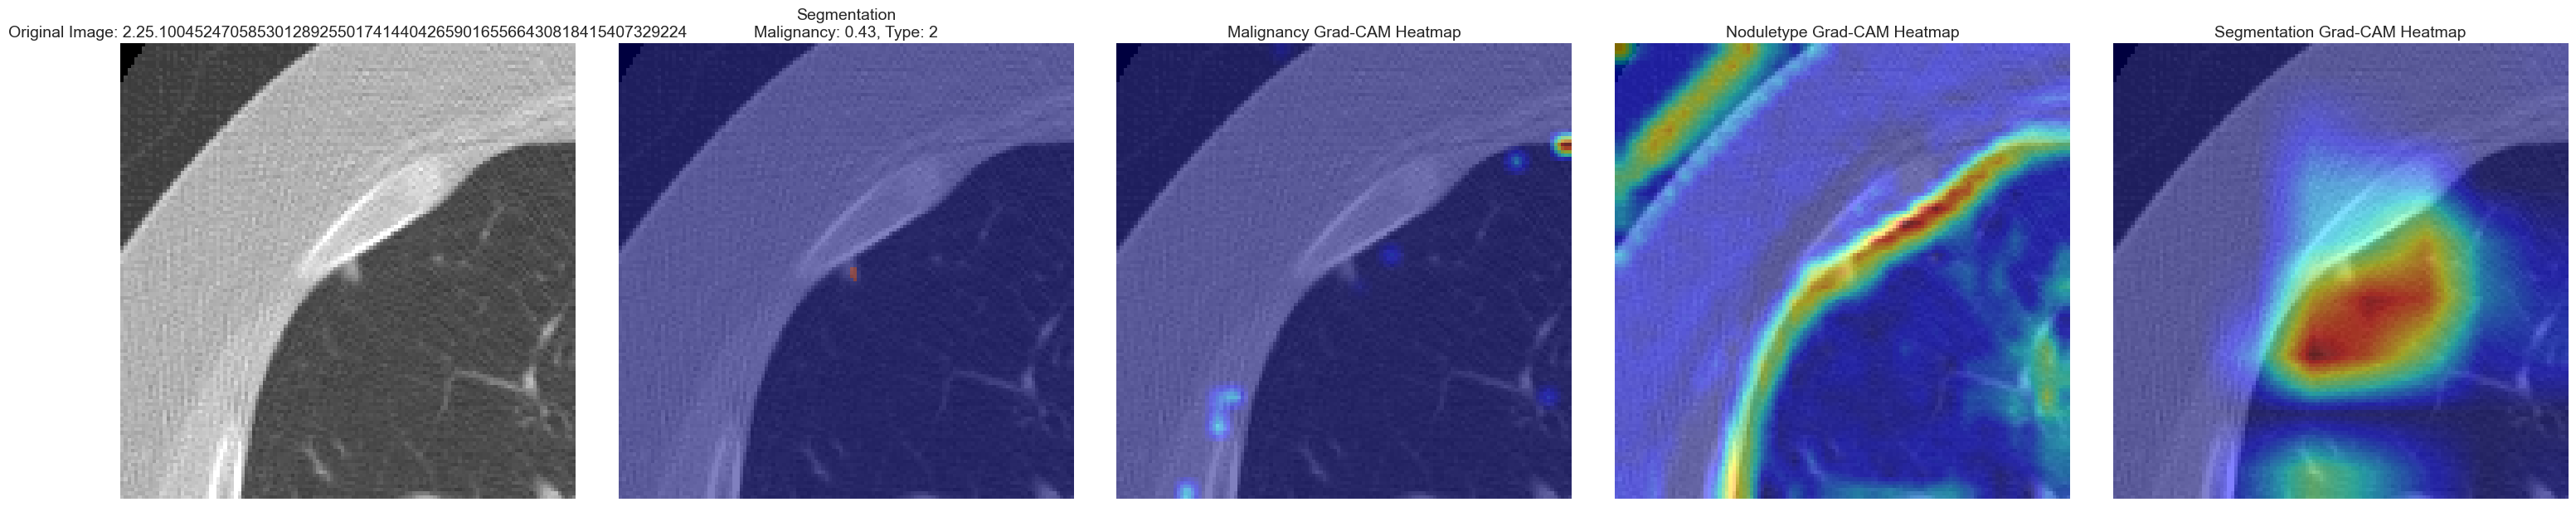

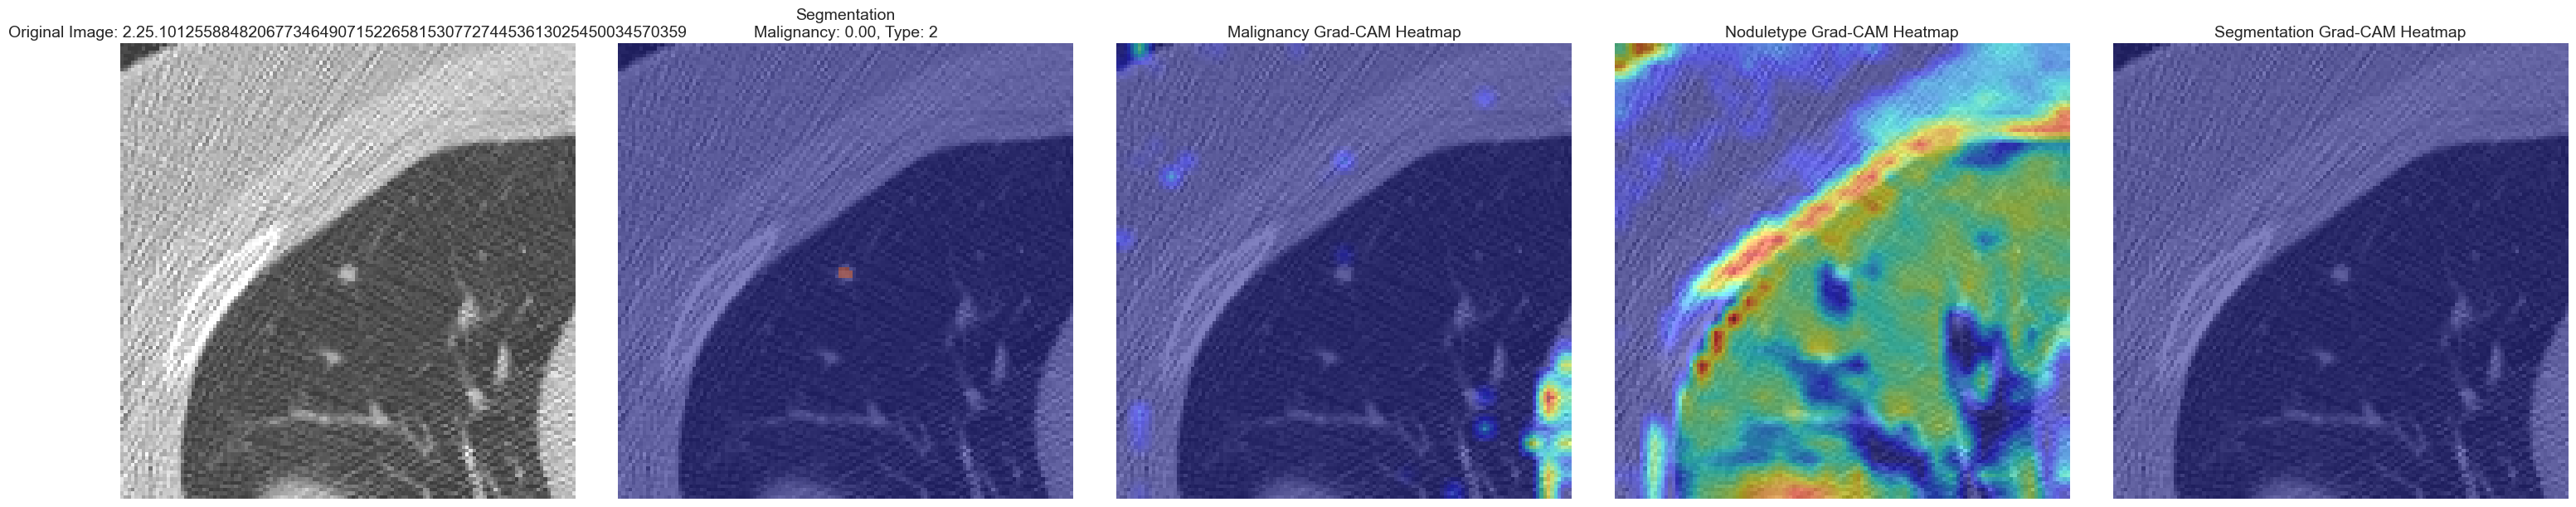

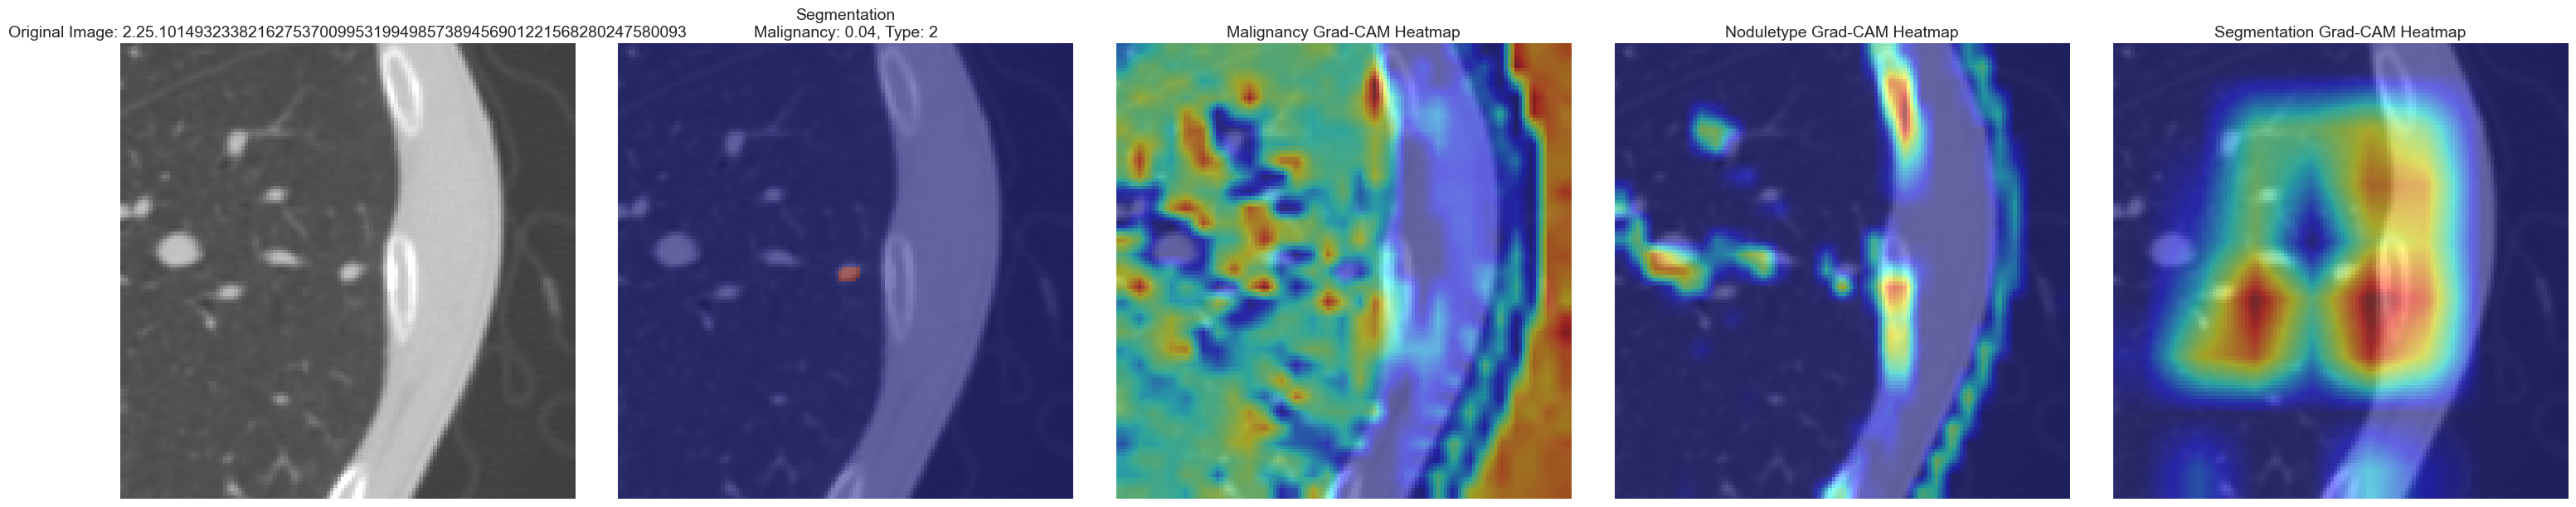

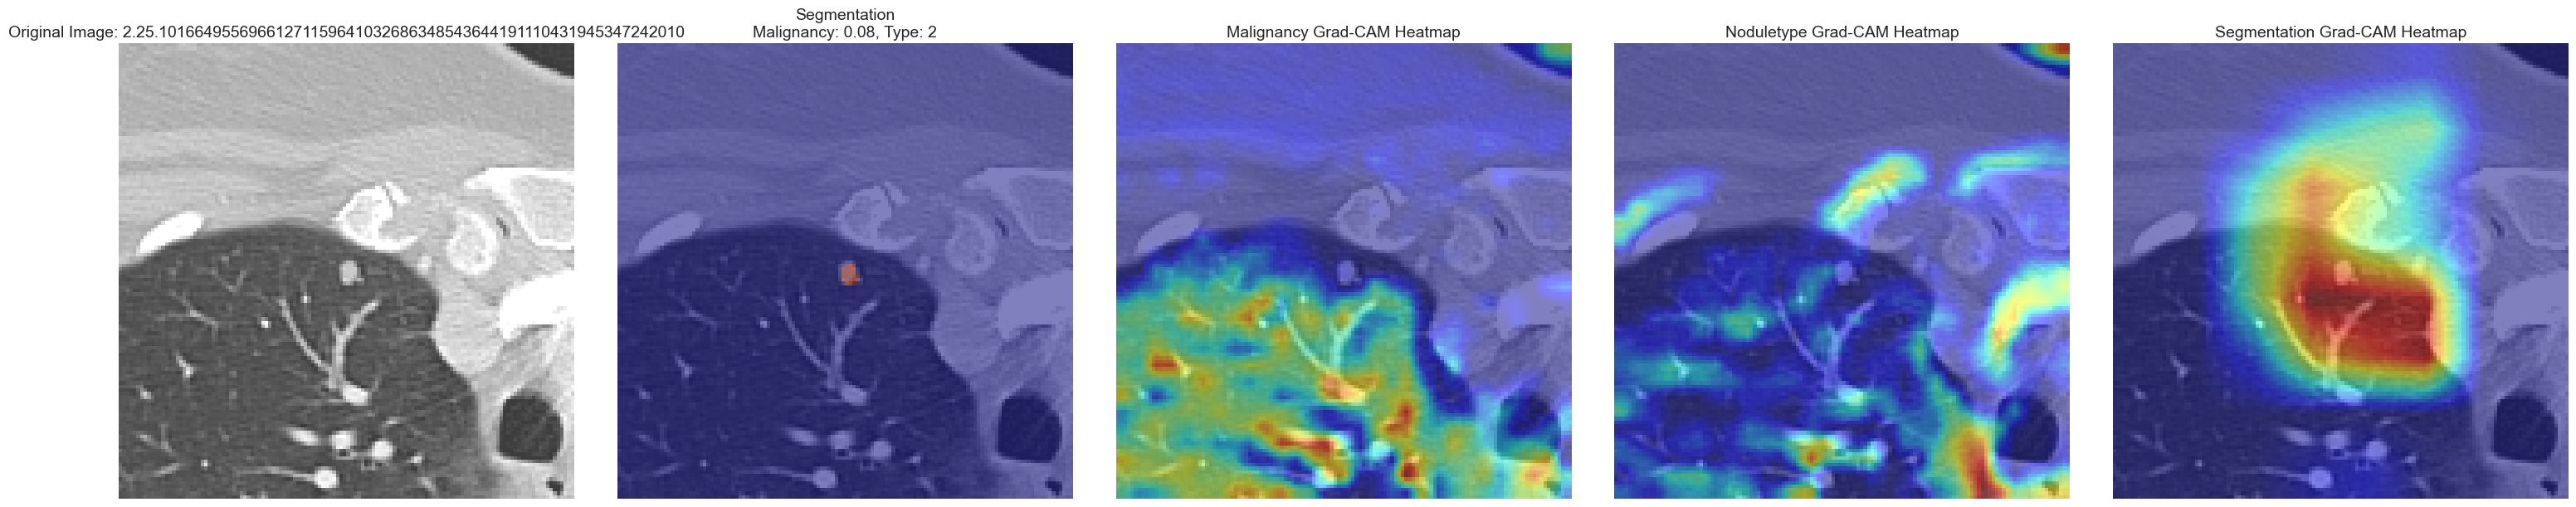

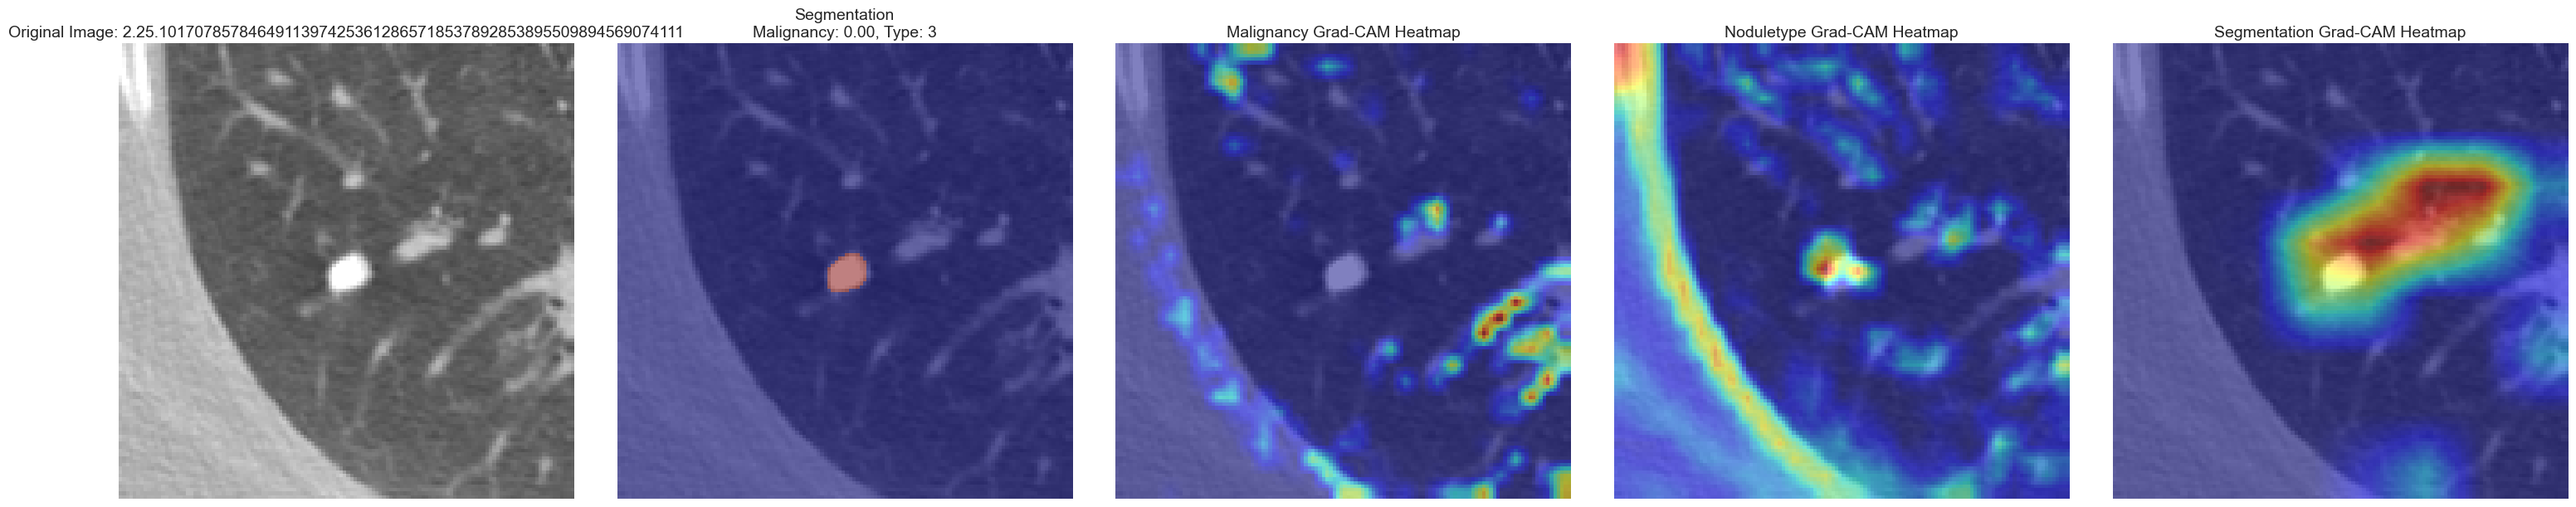

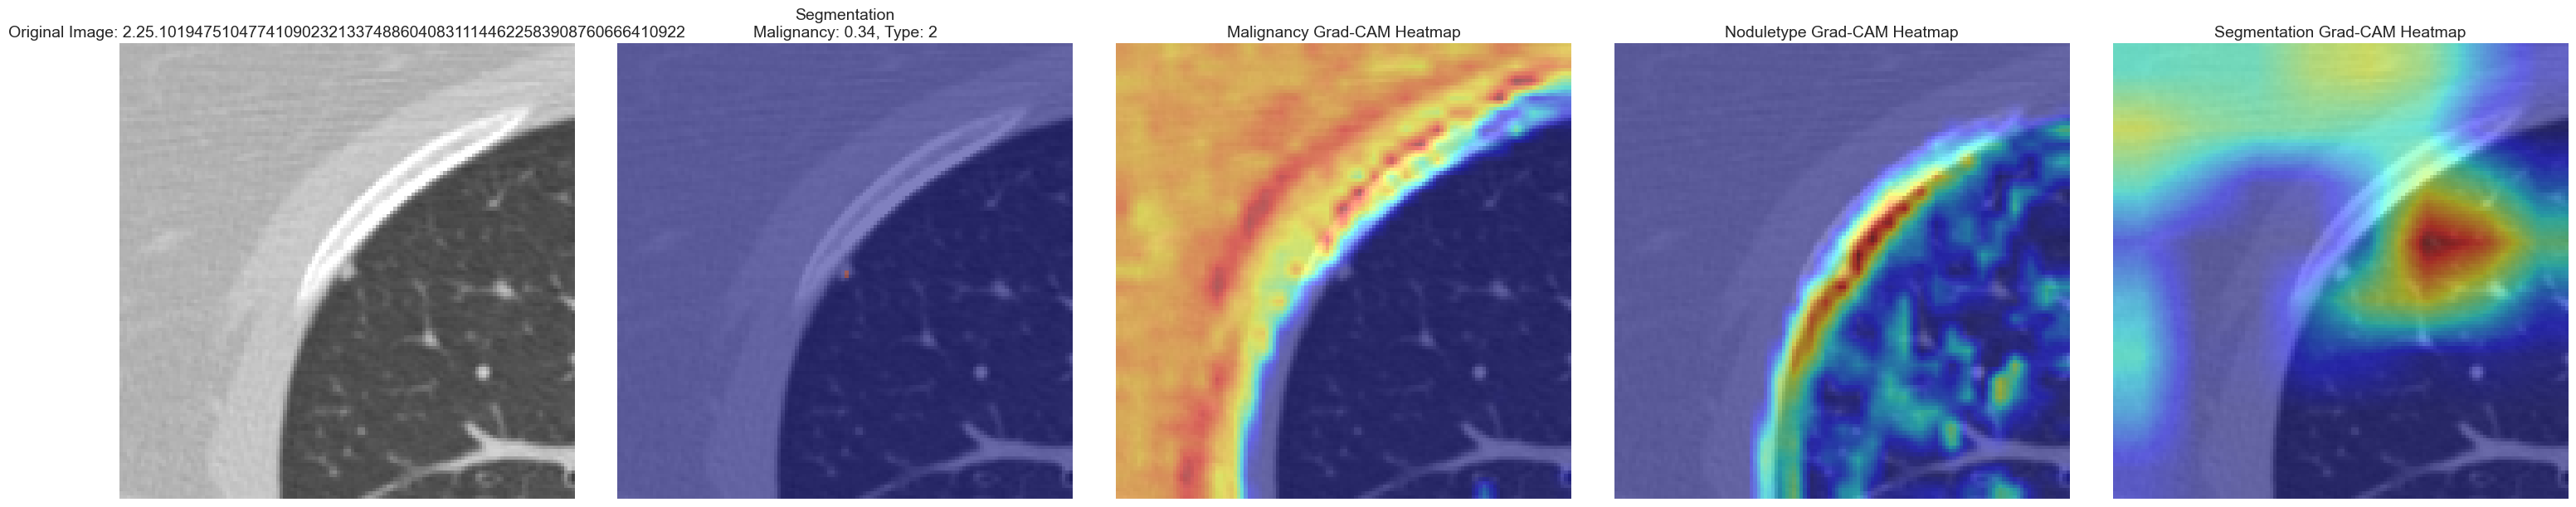

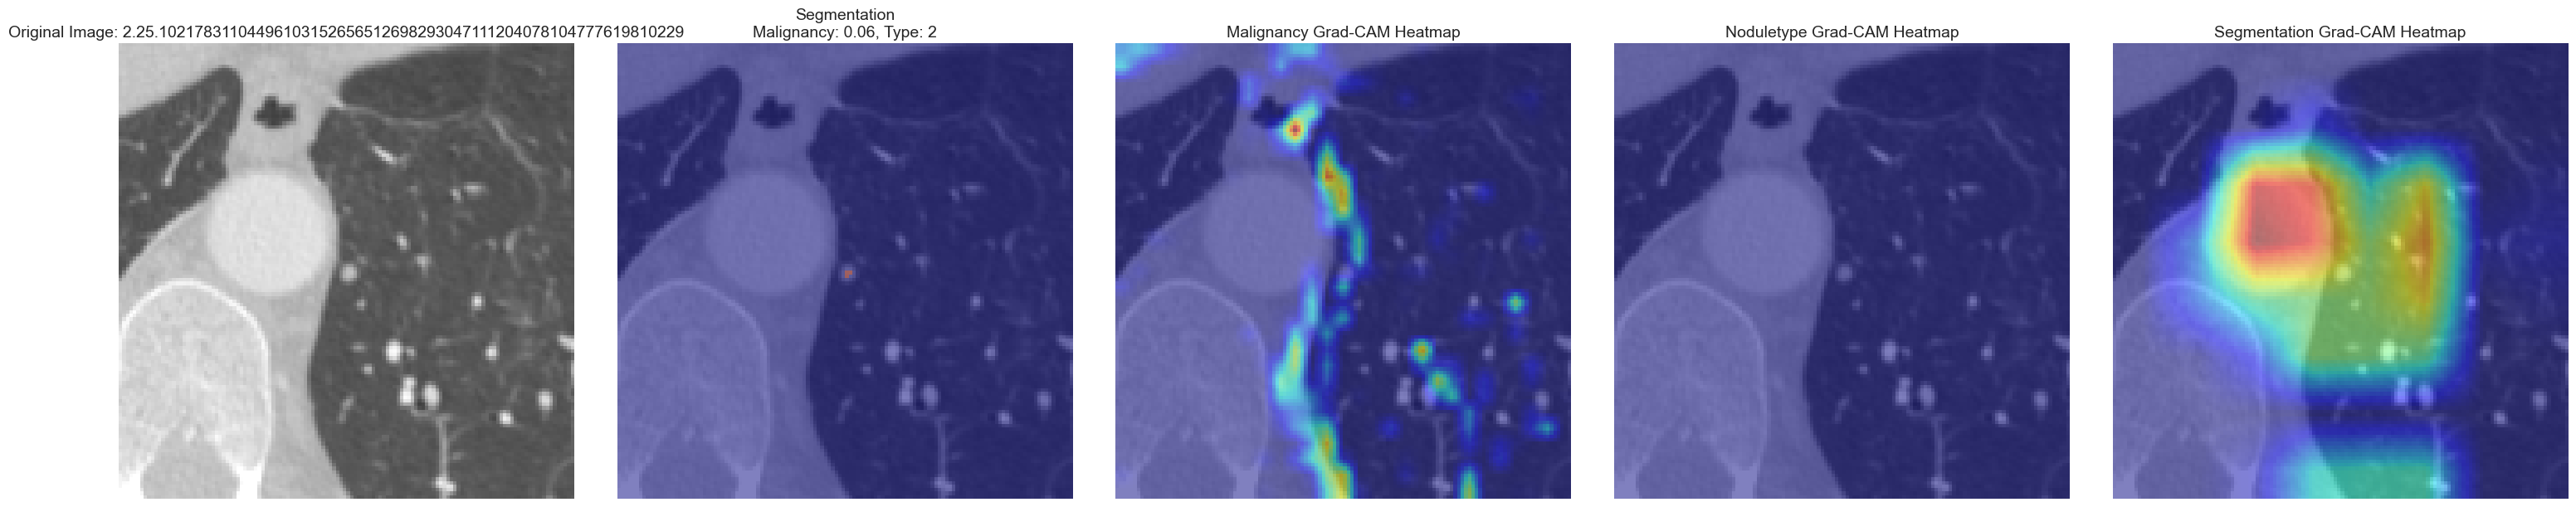

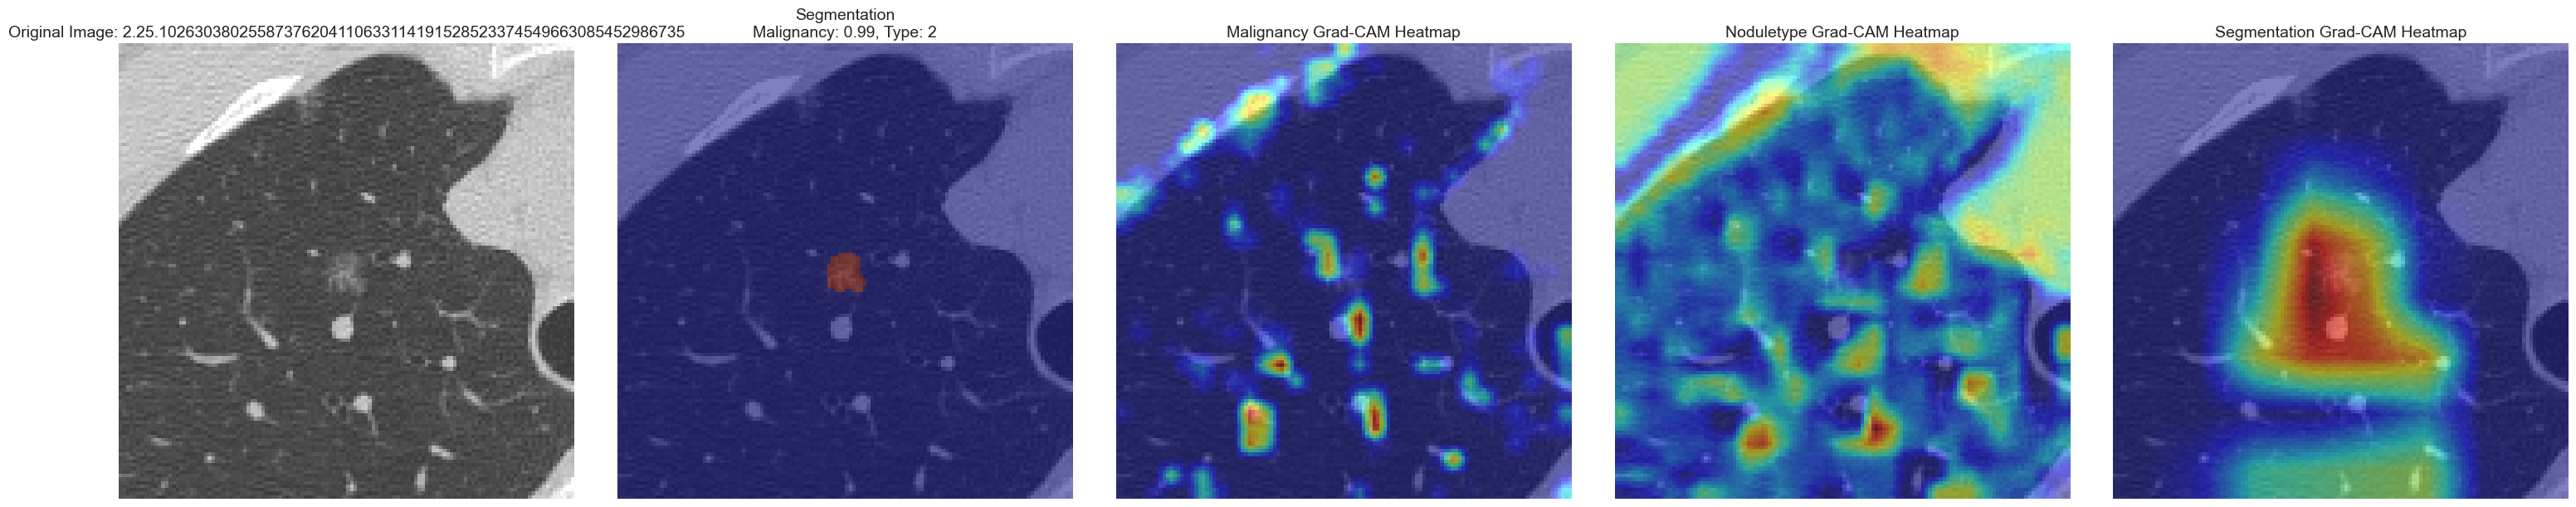

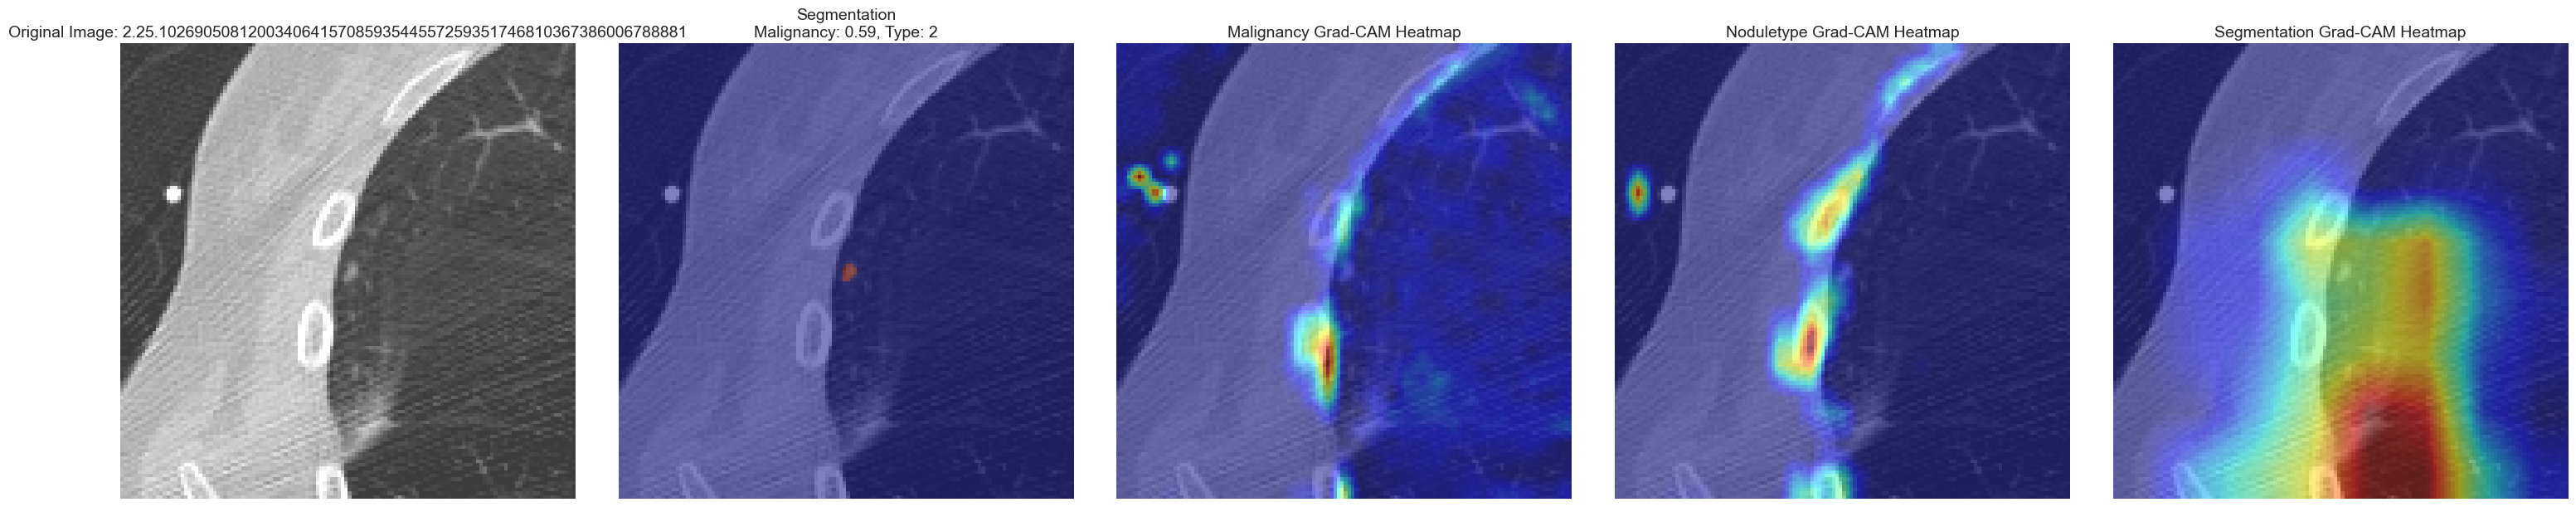

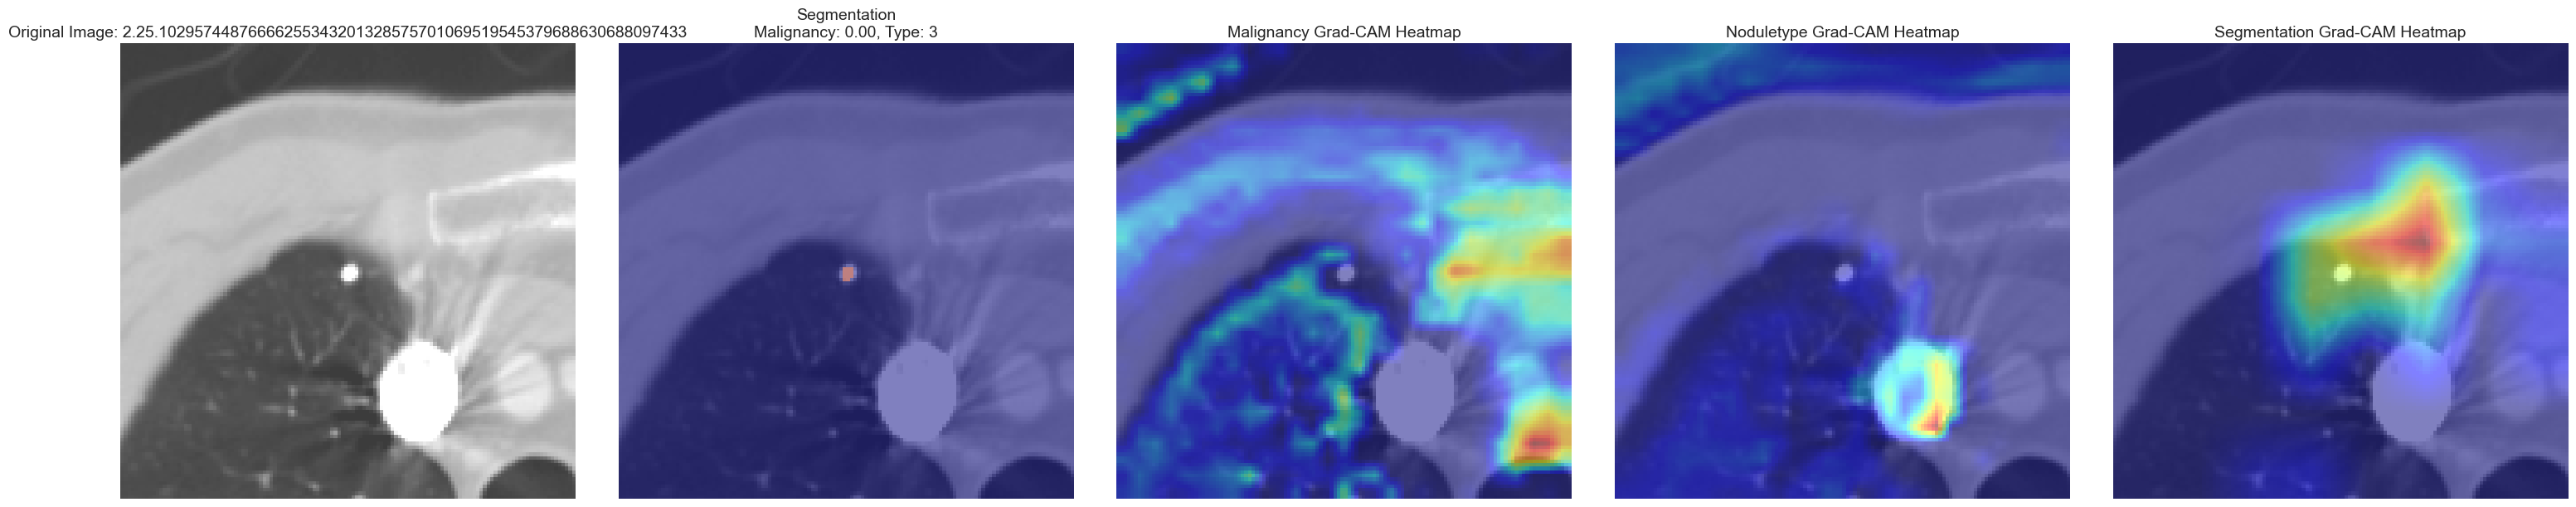

In [19]:
# Iterate over the test set images and create visualizations for original models
for idx, image_path in enumerate(test_set_images_path.glob("*.mha")):
    noduleid = image_path.stem
    prediction = predictions[predictions.noduleid == noduleid].iloc[0]

    create_visualization_original(image_path, prediction, idx, malignancy_model, noduletype_model, segmentation_model,
                                  malignancy_layer, noduletype_layer, segmentation_layer)

    if idx >= 9:  # Limit to 10 images for display
        break

### Summary Statistics and Distributions

In [20]:
# Print summary statistics
print_summary_statistics(predictions)

Summary Statistics for Predictions
---------------------------------
Total Number of Nodules: 256
Average Malignancy Probability: 0.3800
Standard Deviation of Malignancy Probability: 0.4037
Nodule Type Distribution:
2    179
3     69
0      7
1      1
Name: noduletype, dtype: int64



### Plot Distributions for Baseline Models (Both Malignancy and Nodule Type)

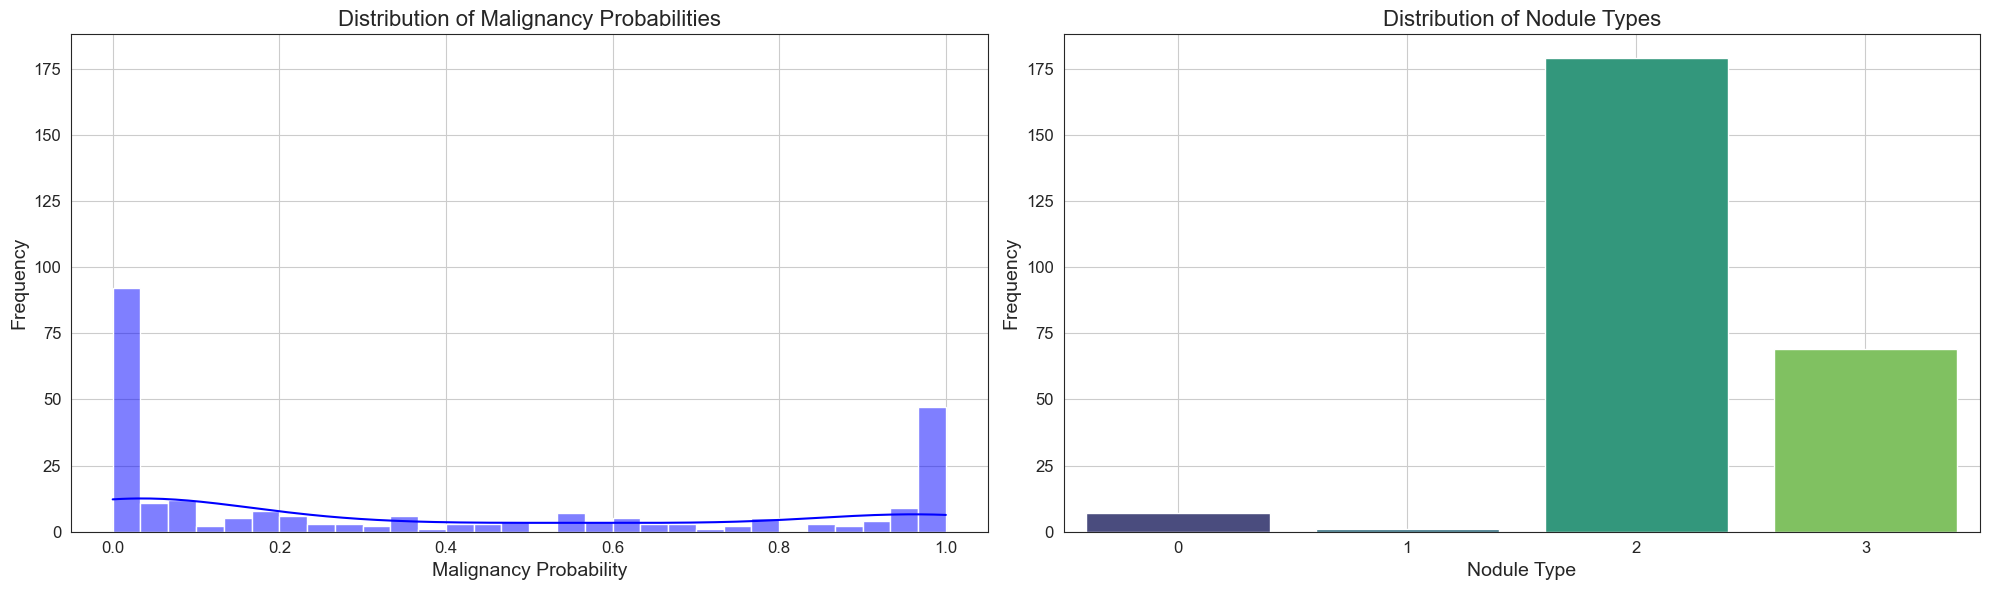

In [21]:
# Plot the distributions
plot_distributions(predictions)

## Third Approach Results
### Grad-CAM Heatmaps Comparison for Nodule Type - Original and ViT Models

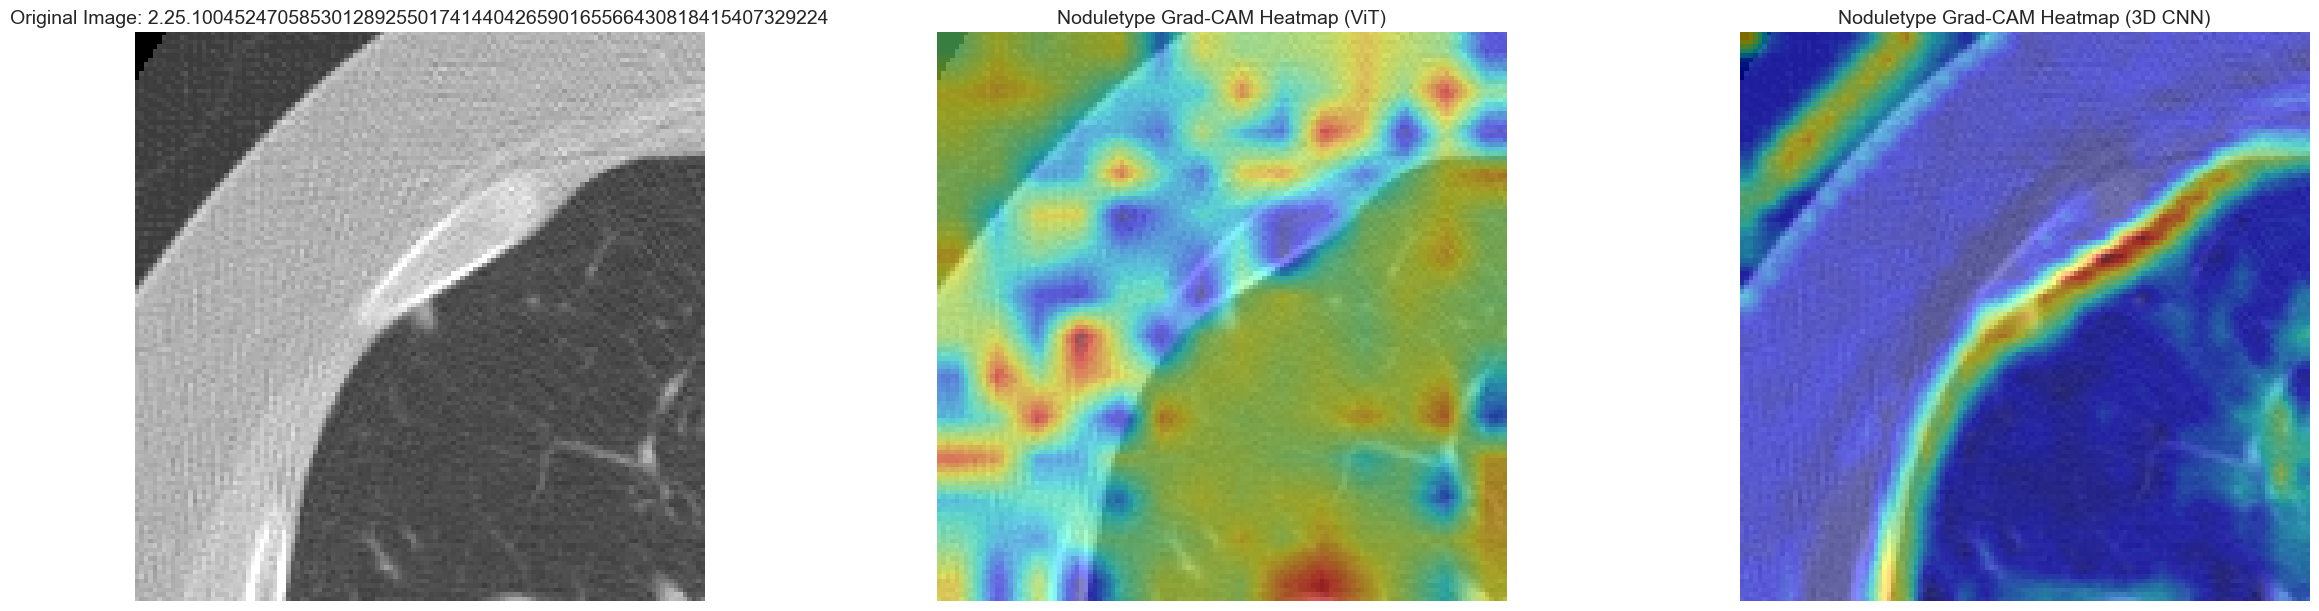

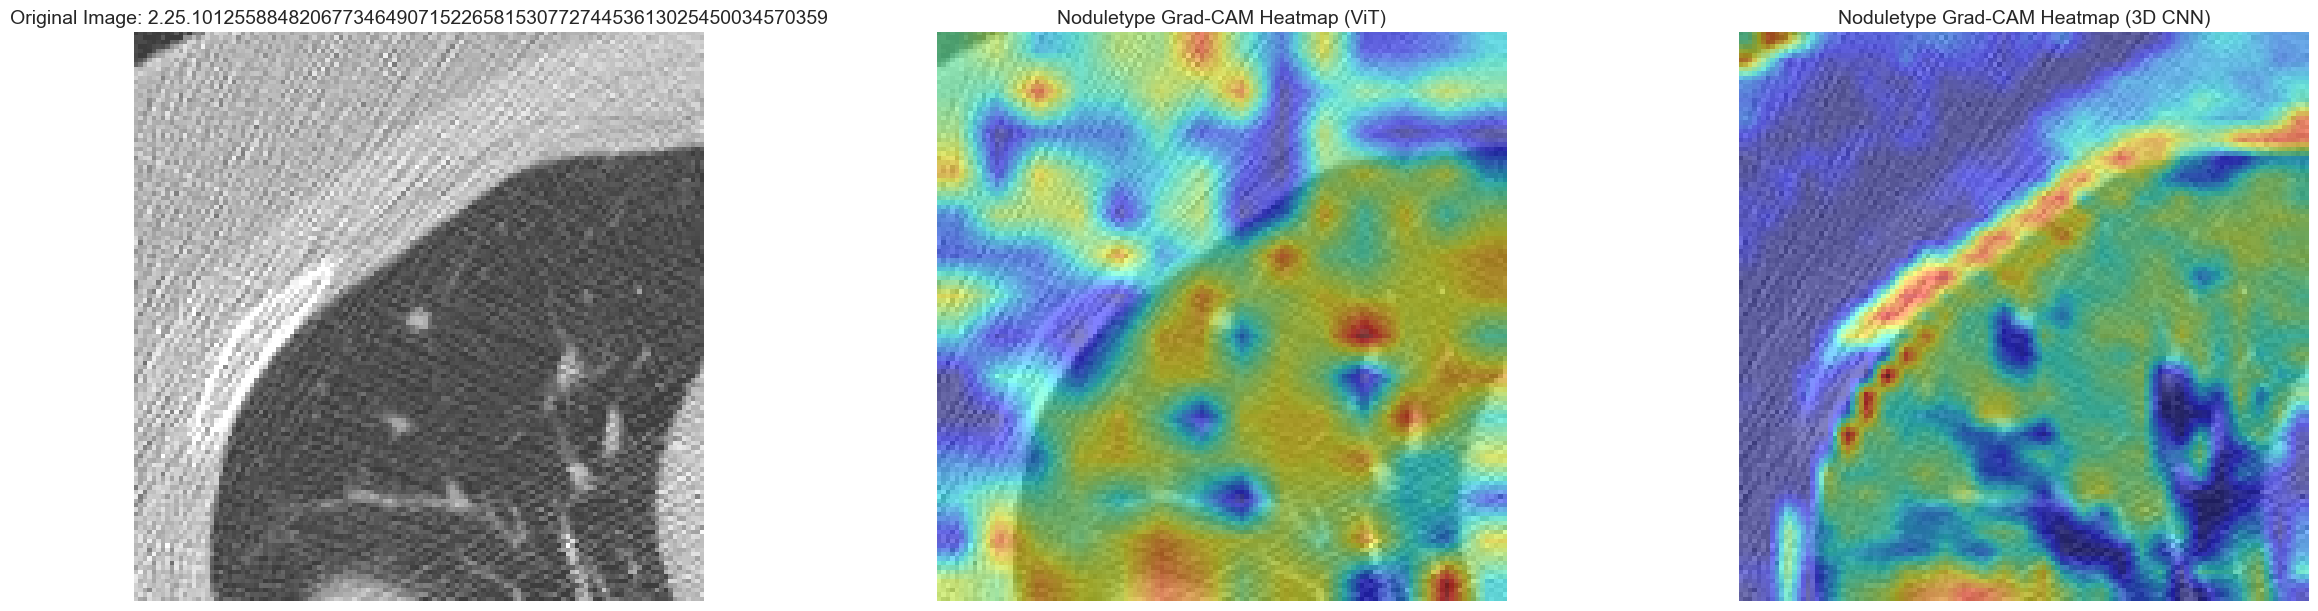

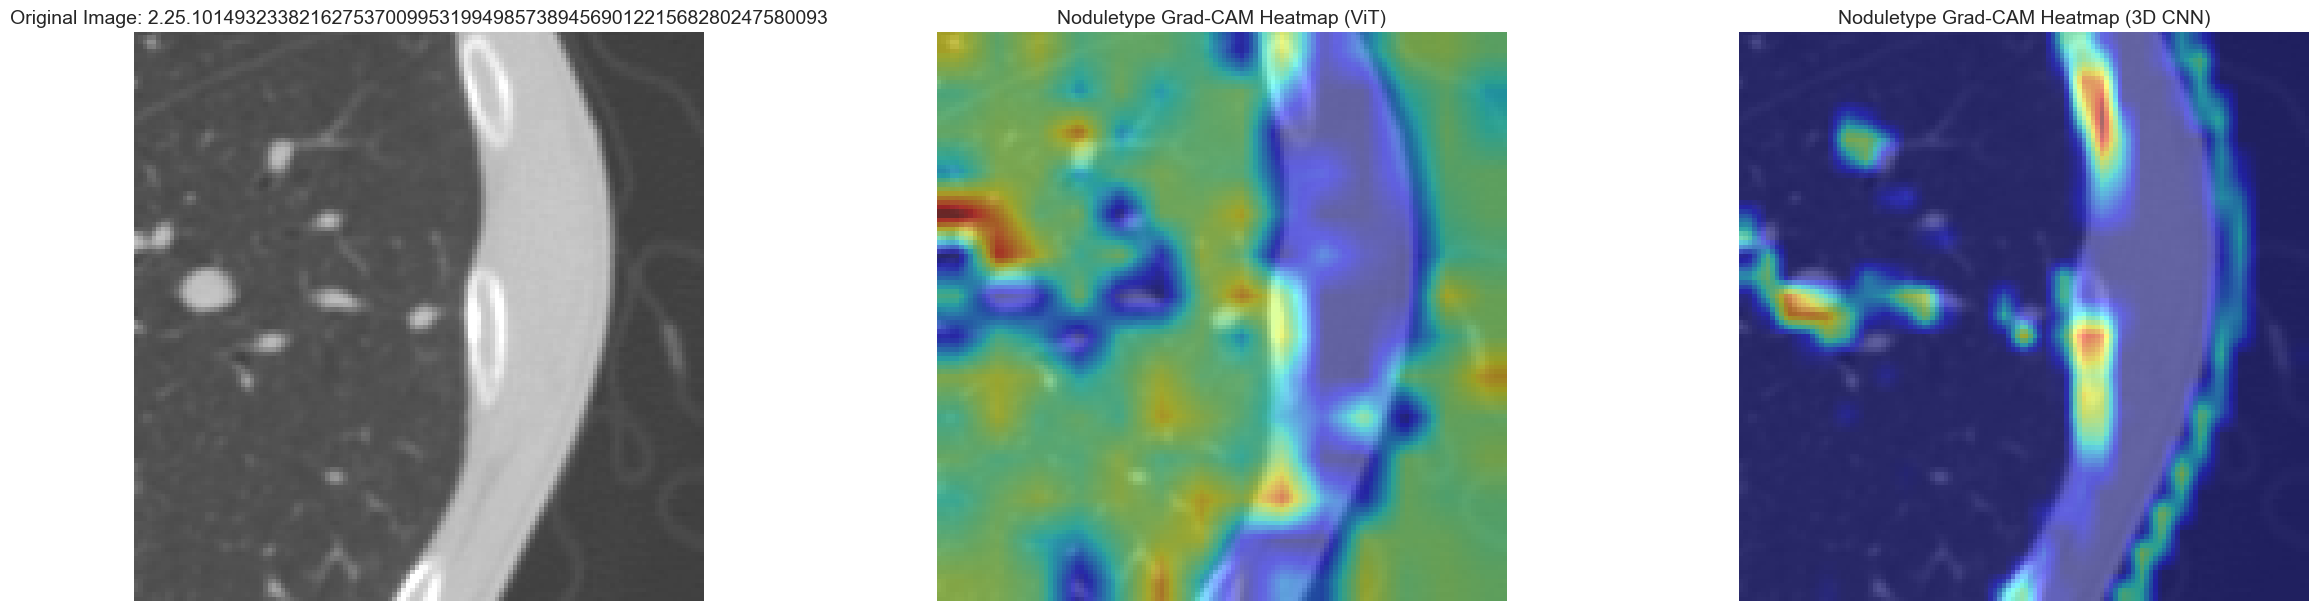

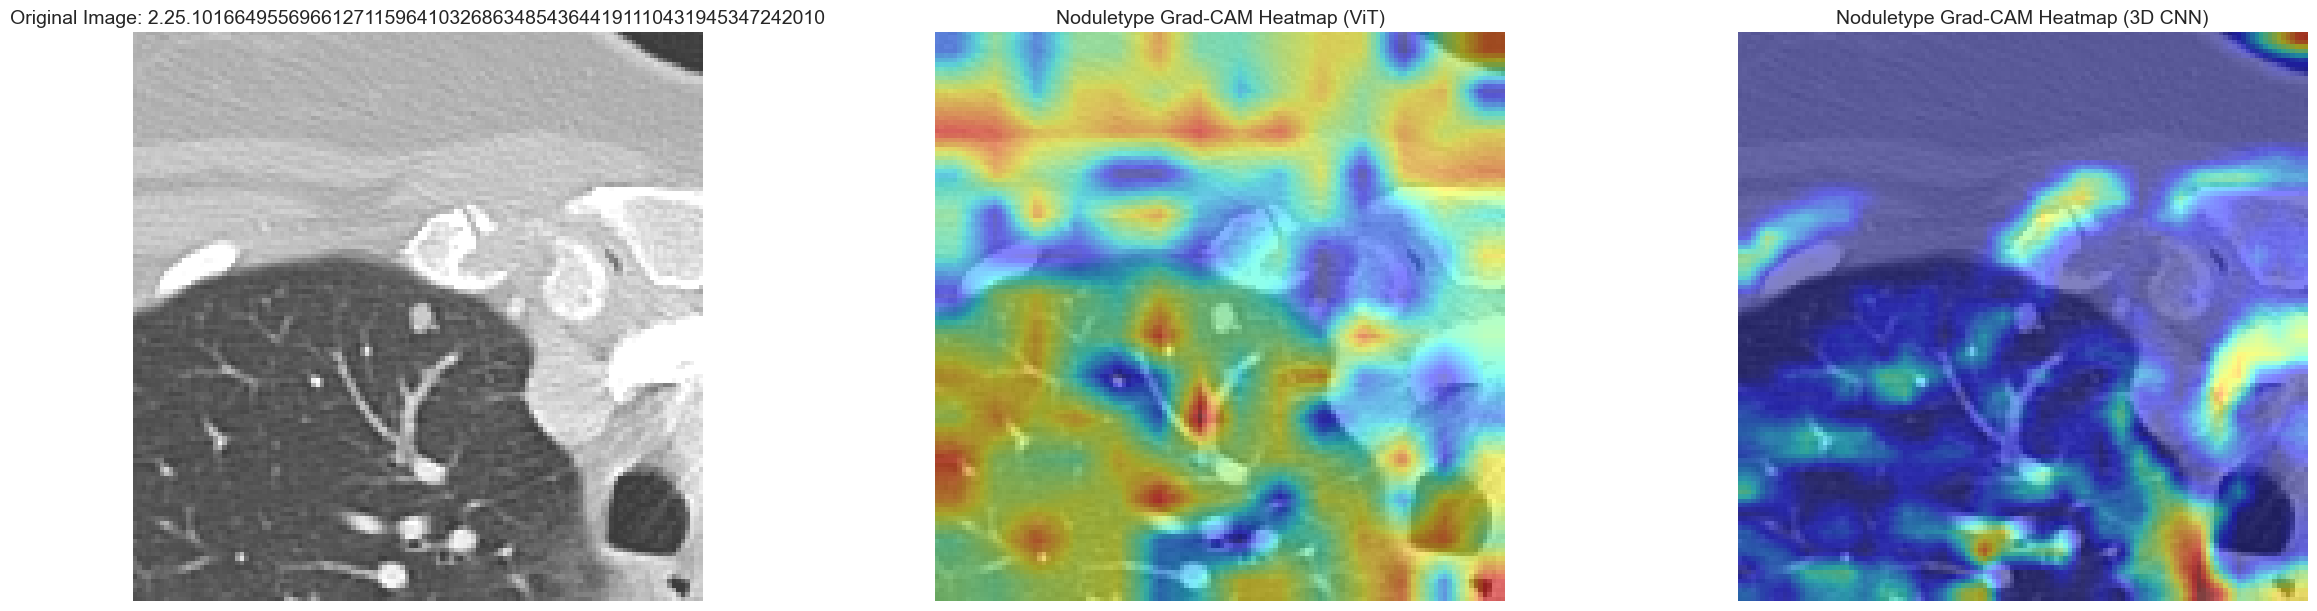

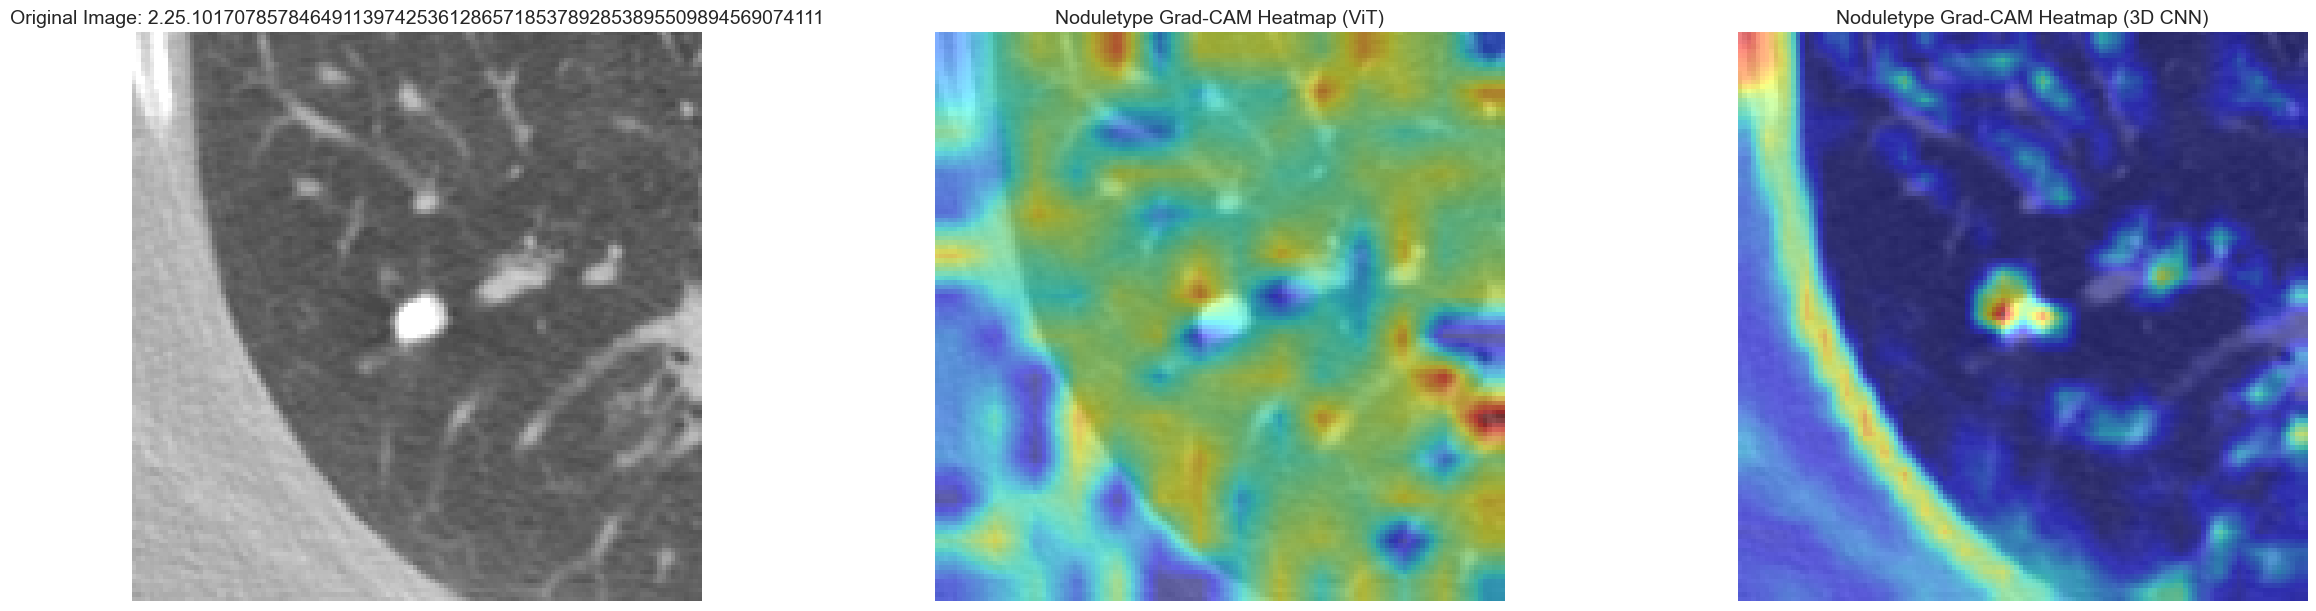

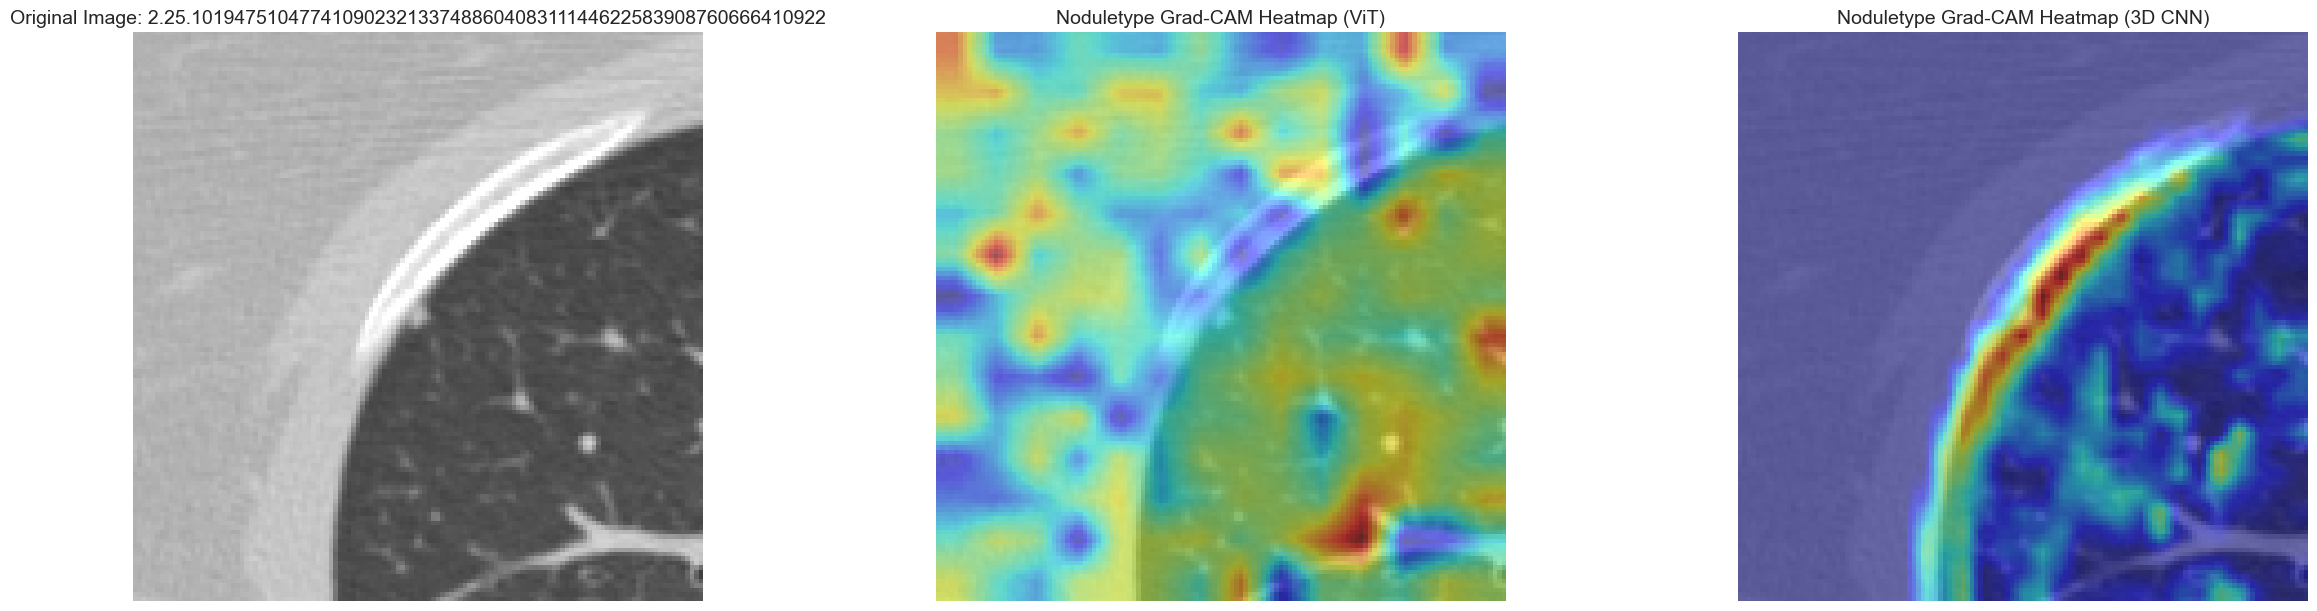

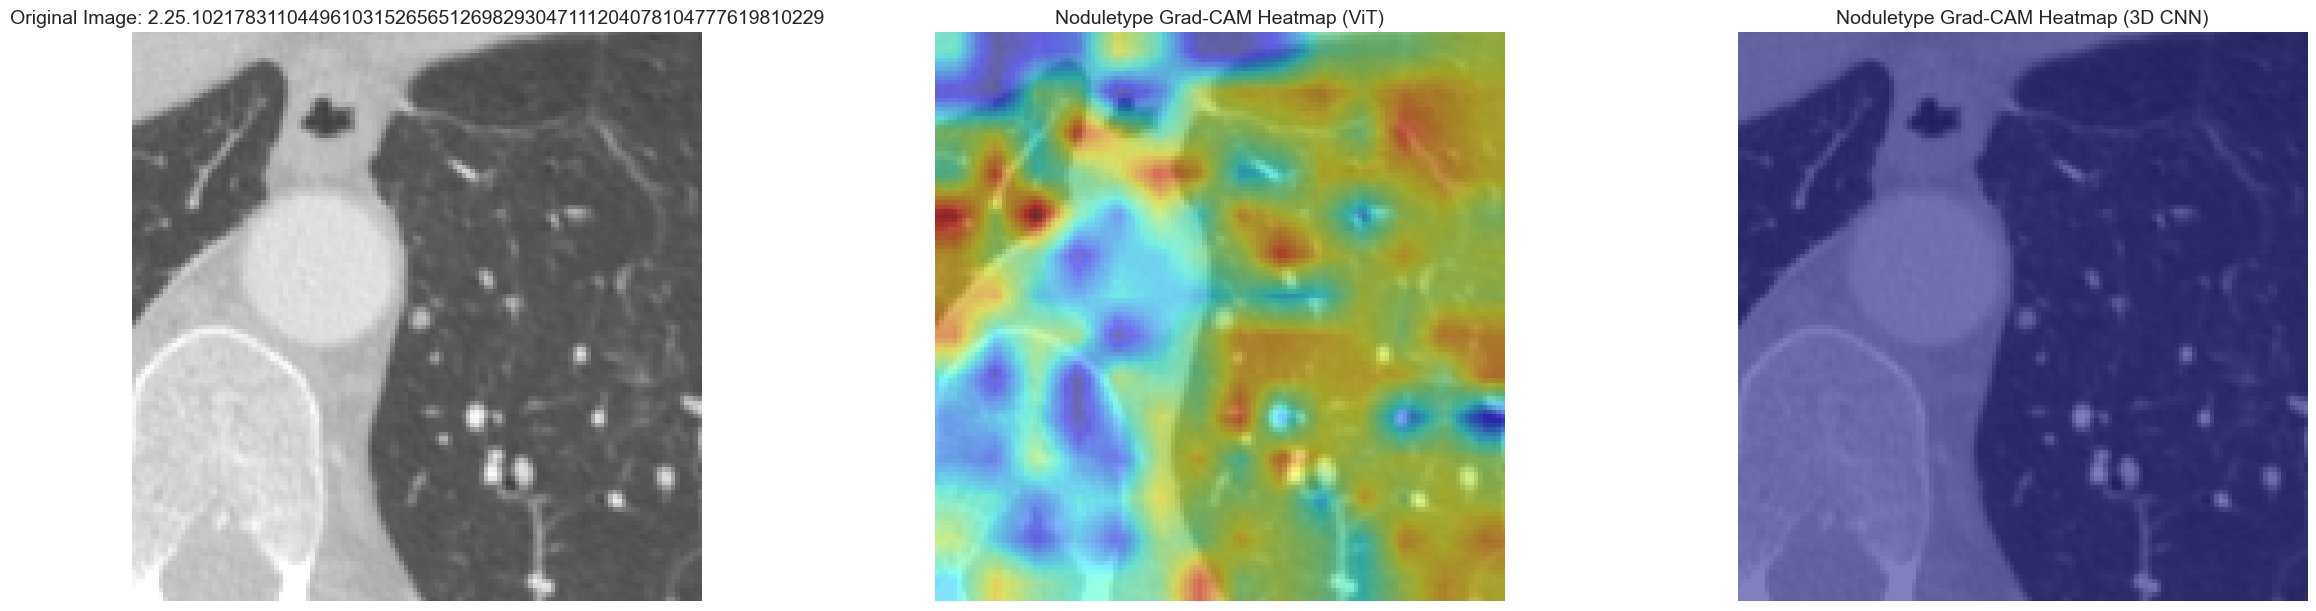

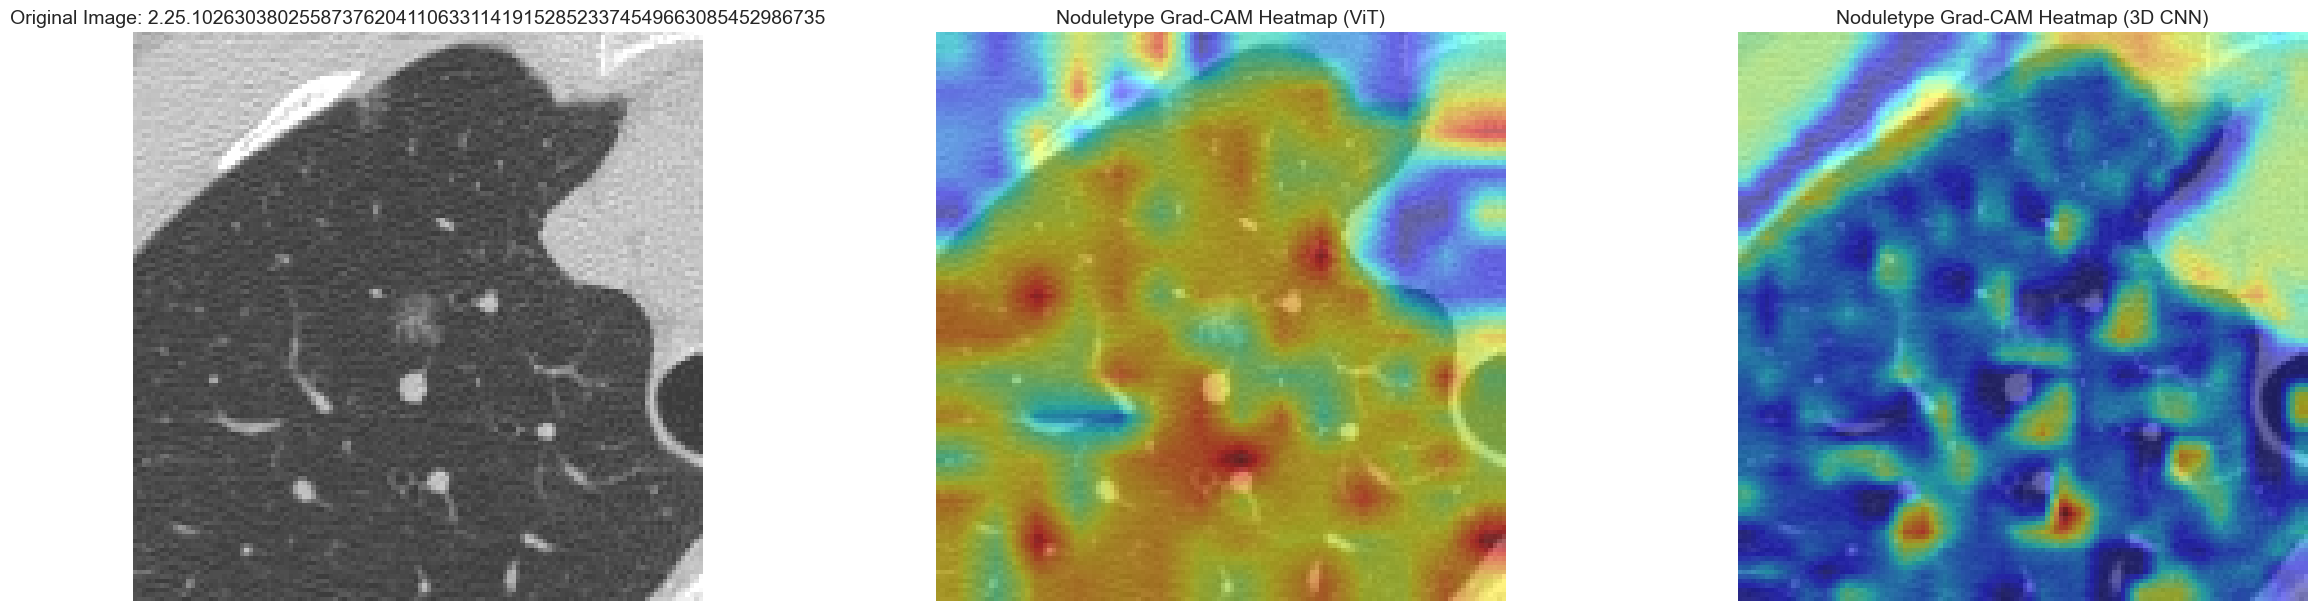

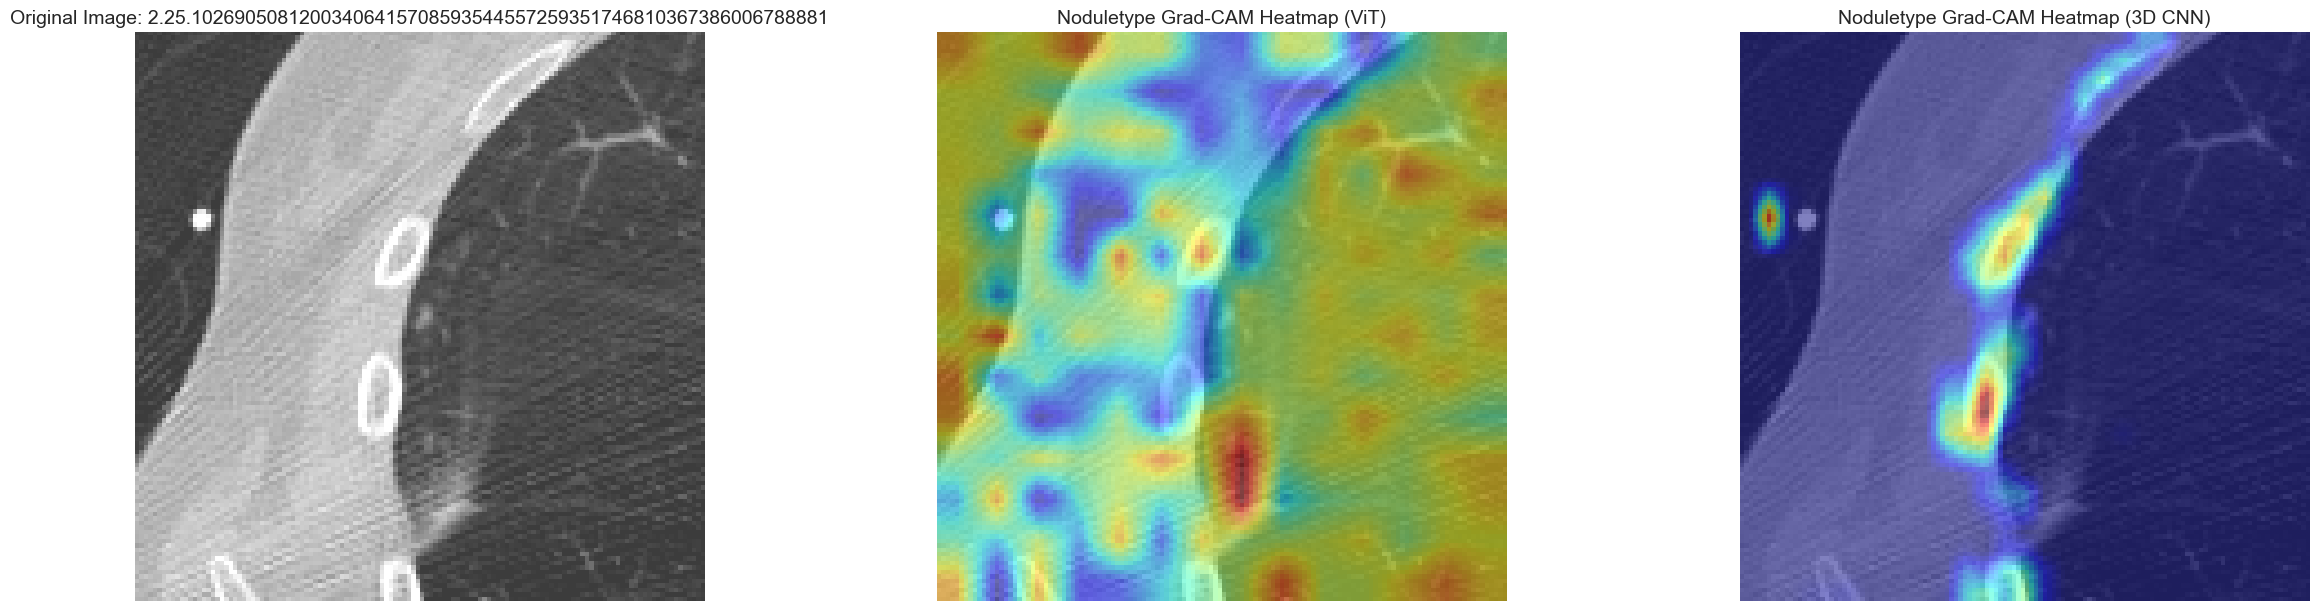

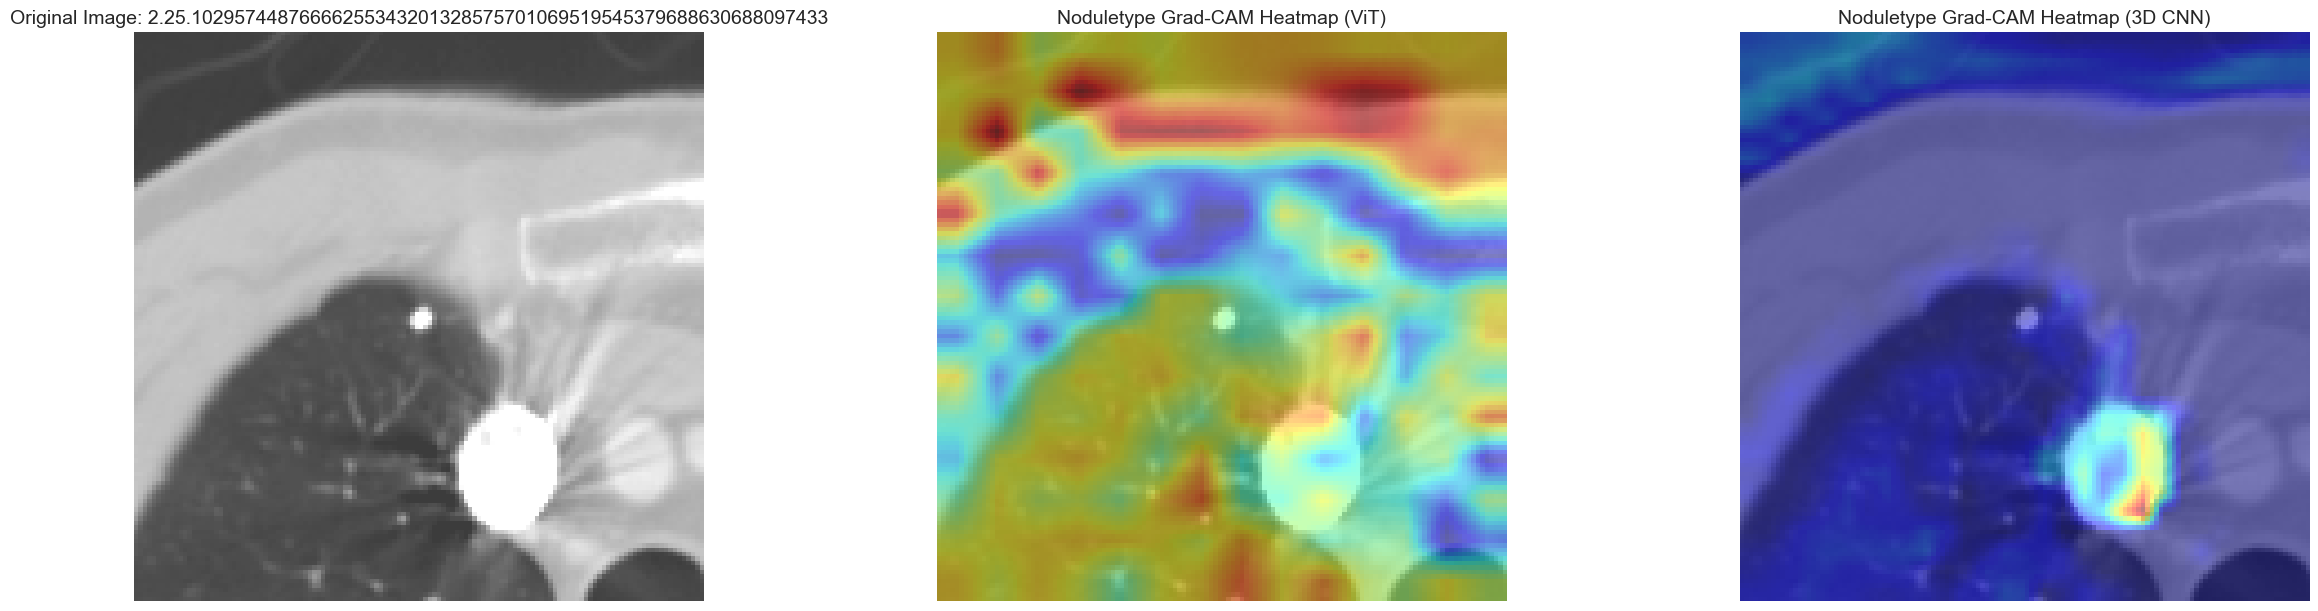

In [22]:
# Iterate over the test set images and create visualizations for original models
for idx, image_path in enumerate(test_set_images_path.glob("*.mha")):
    noduleid = image_path.stem
    prediction = predictions[predictions.noduleid == noduleid].iloc[0]

    create_visualization_vit_cnn(image_path, prediction, idx, vit_model, vit_layer, noduletype_model, noduletype_layer)

    if idx >= 9:  # Limit to 10 images for display
        break

## Fourth Approach Results
### Grad-CAM Heatmaps Comparison for Malignancy - Original and Balanced Models

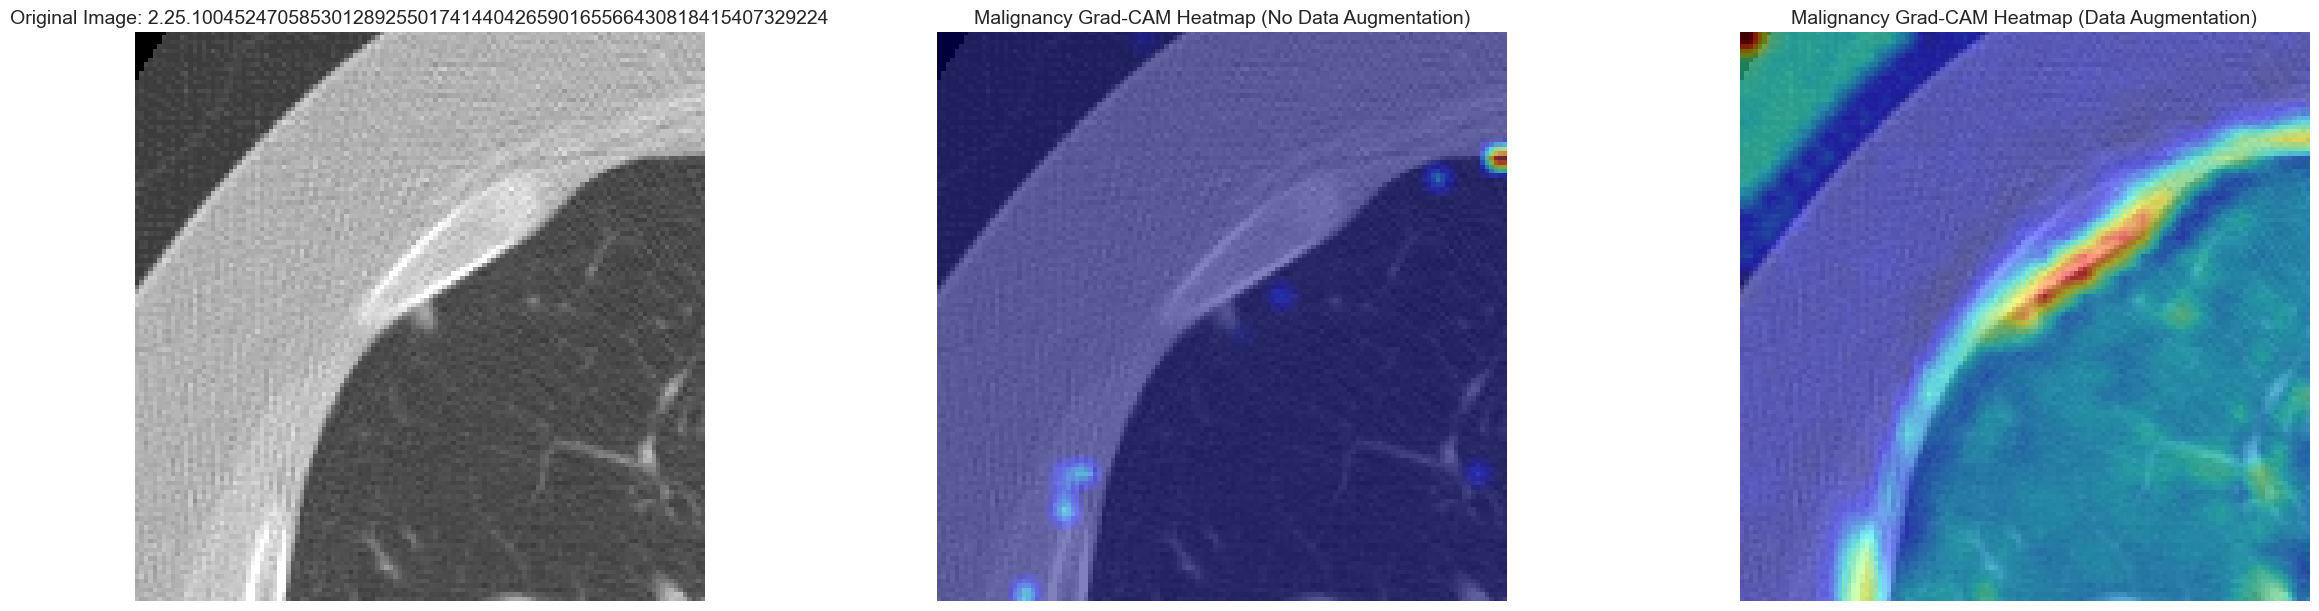

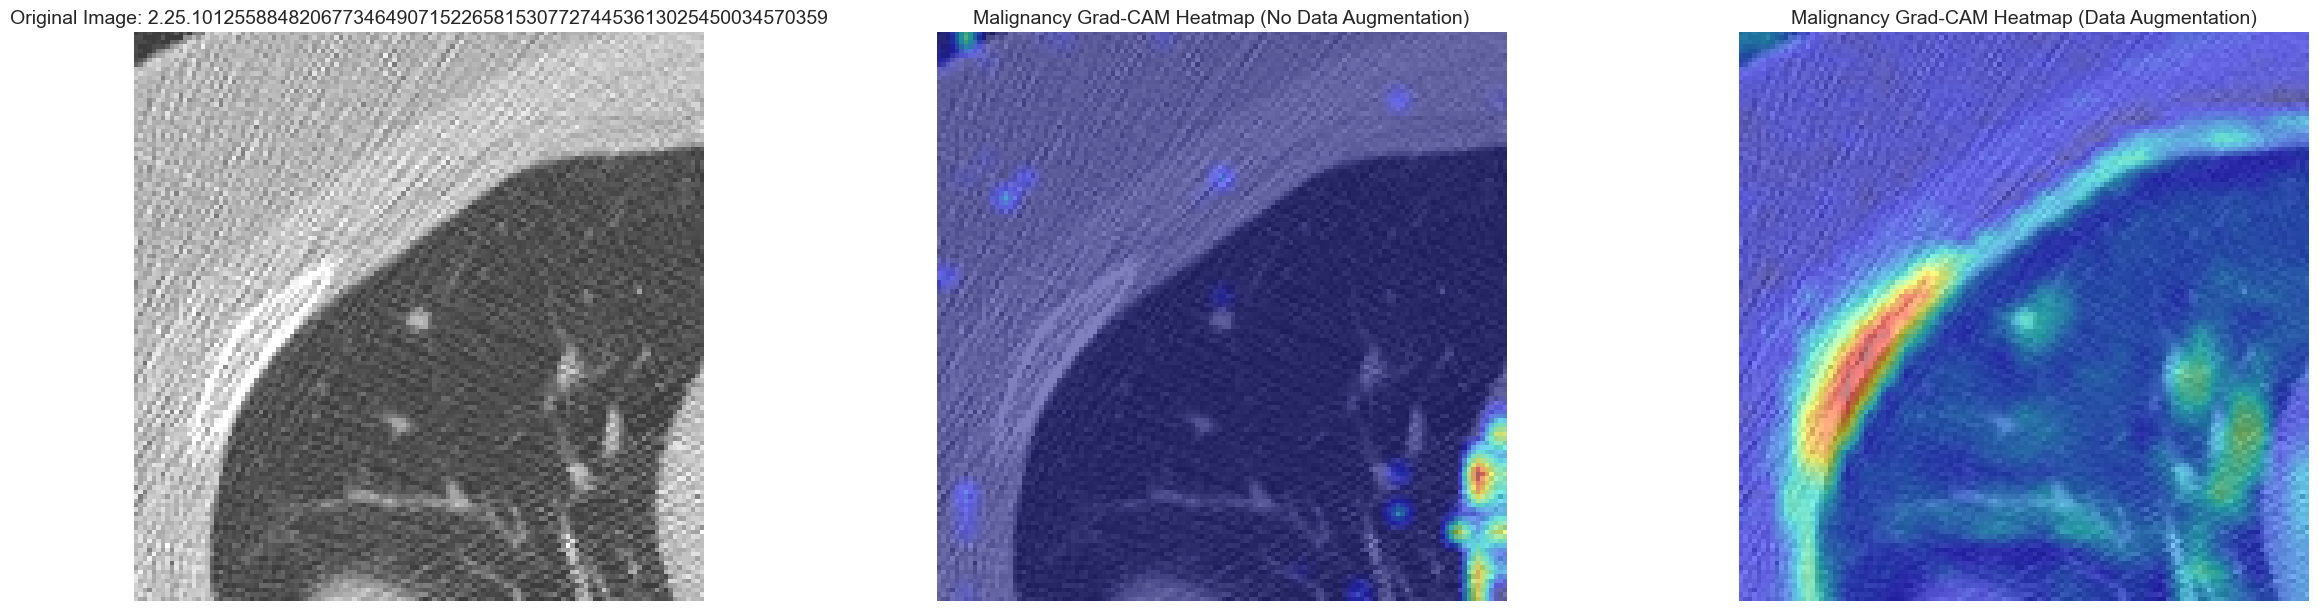

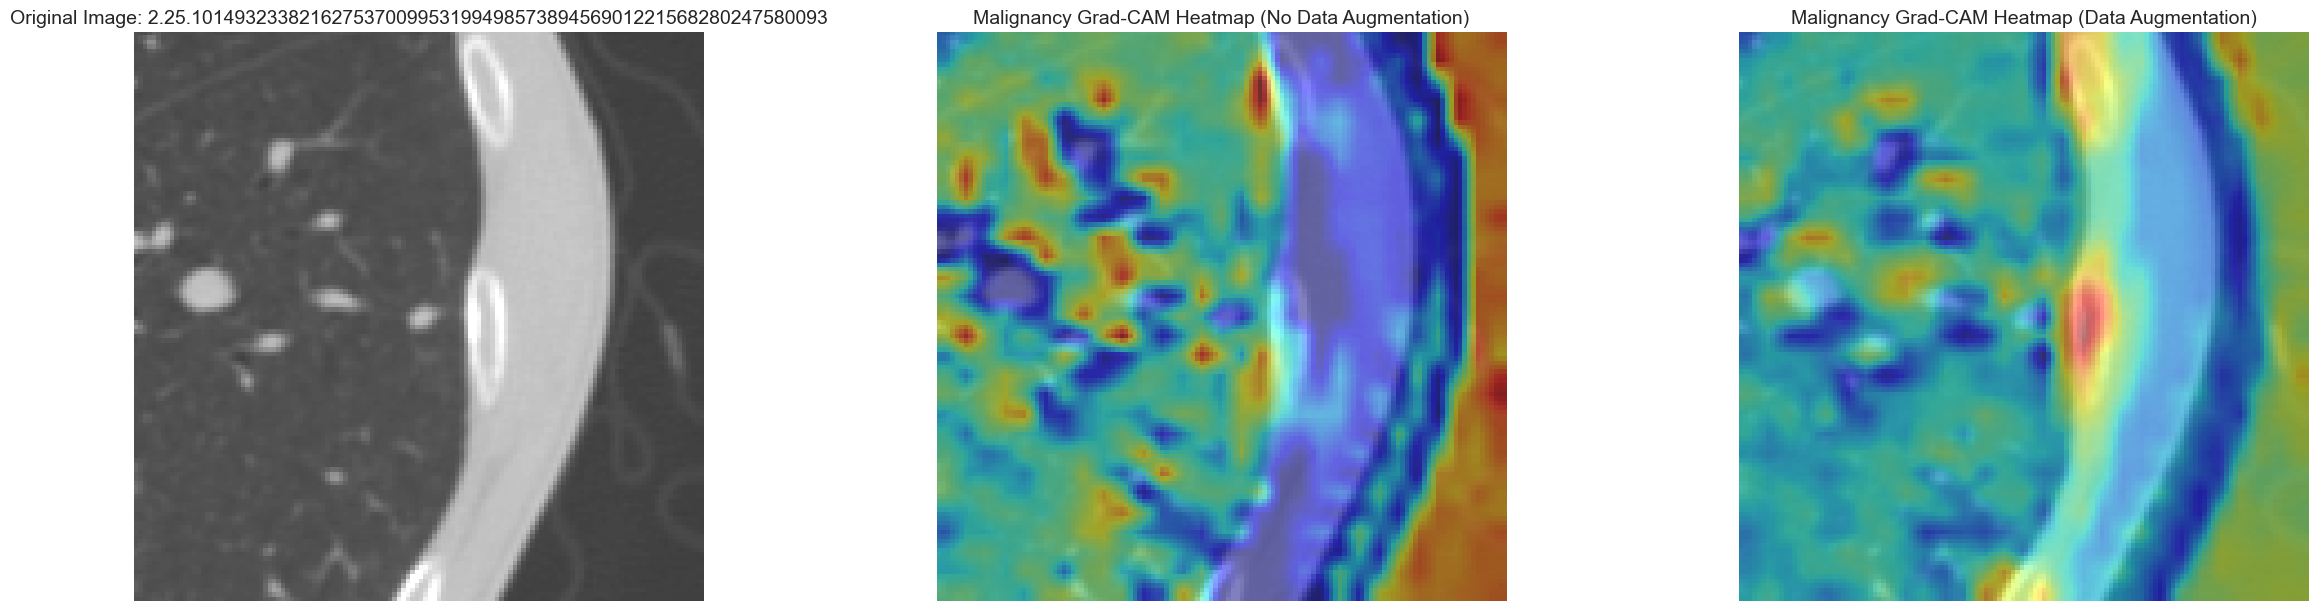

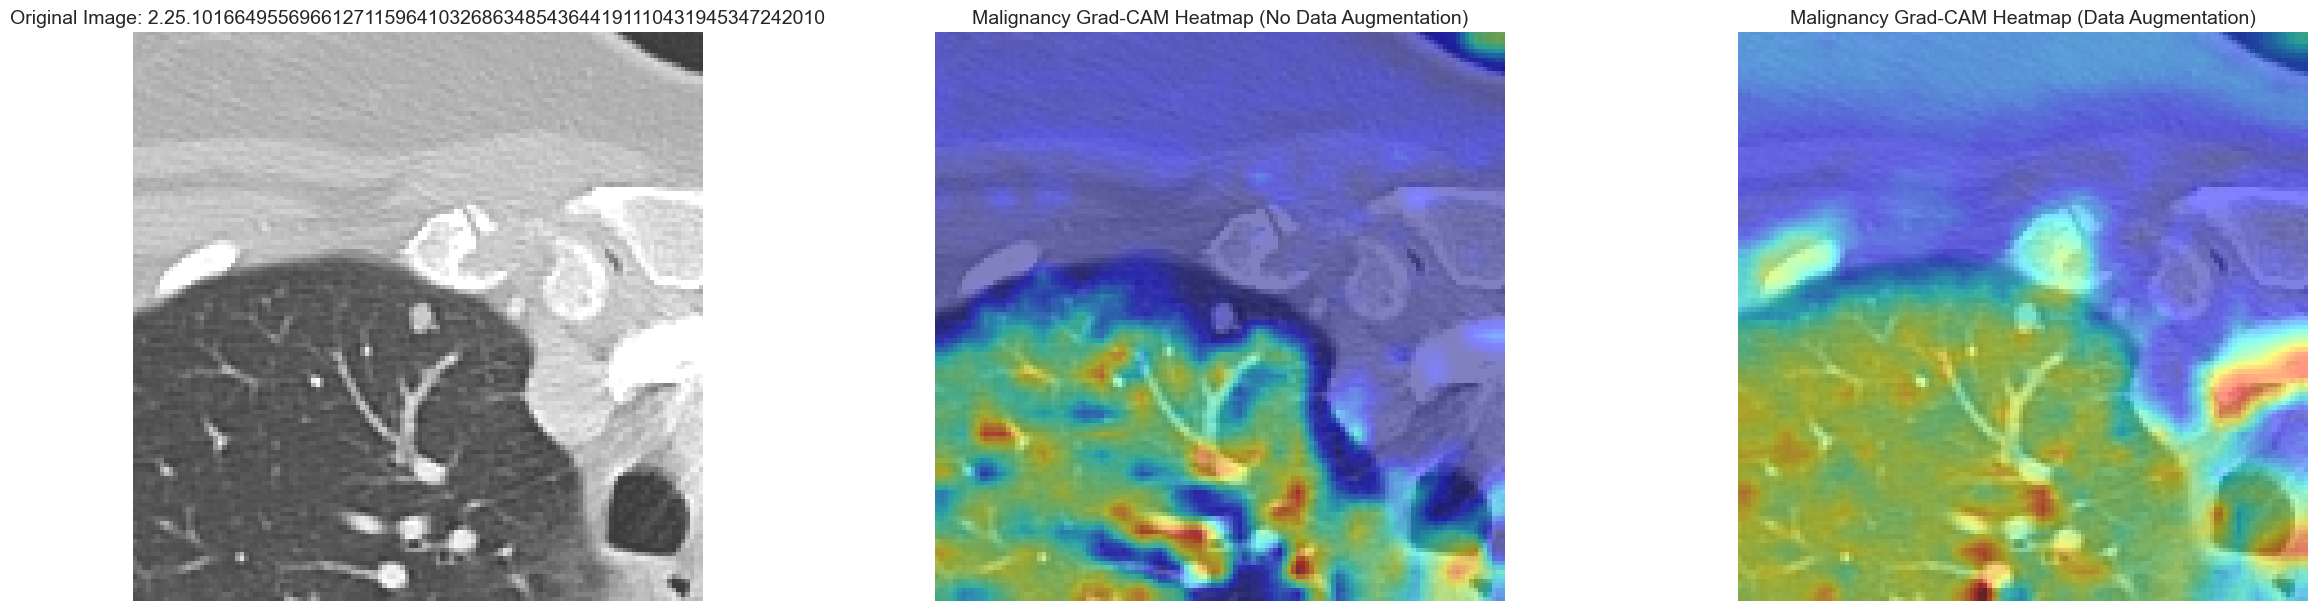

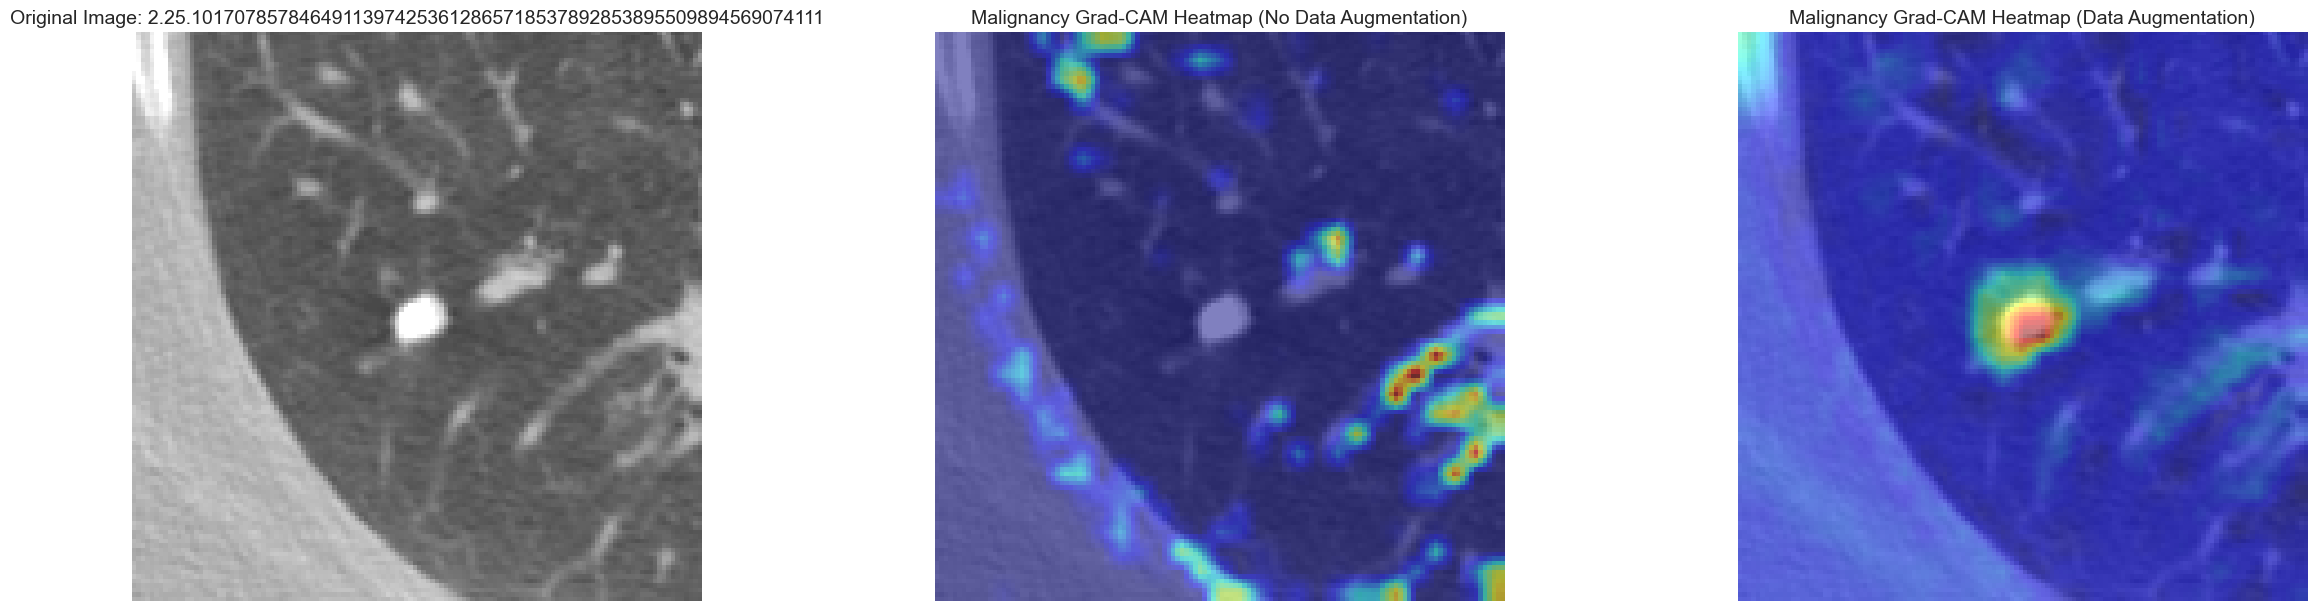

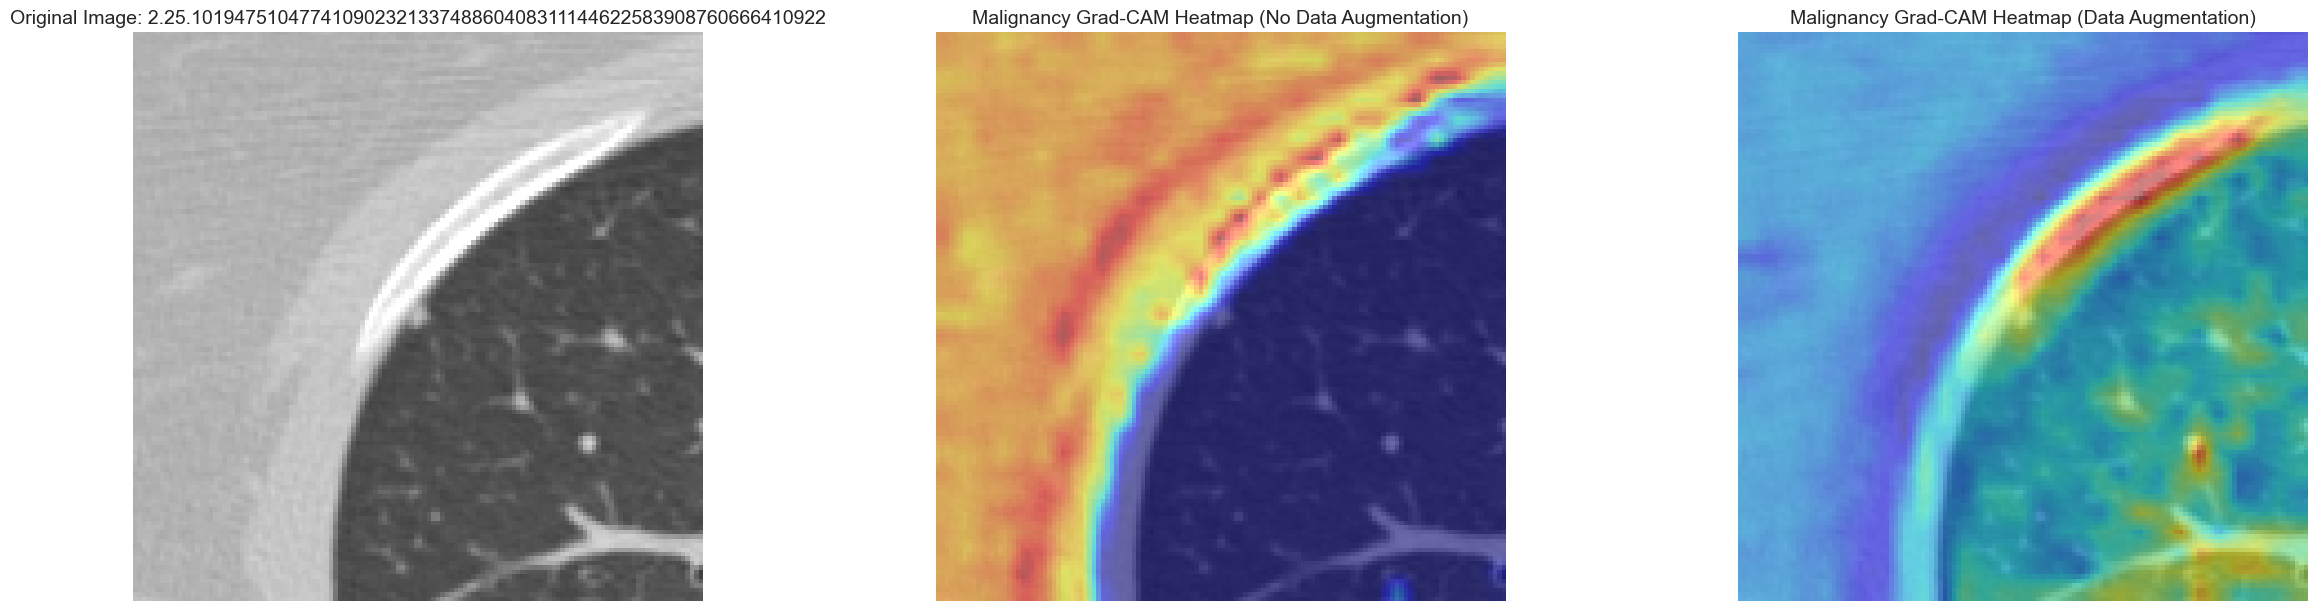

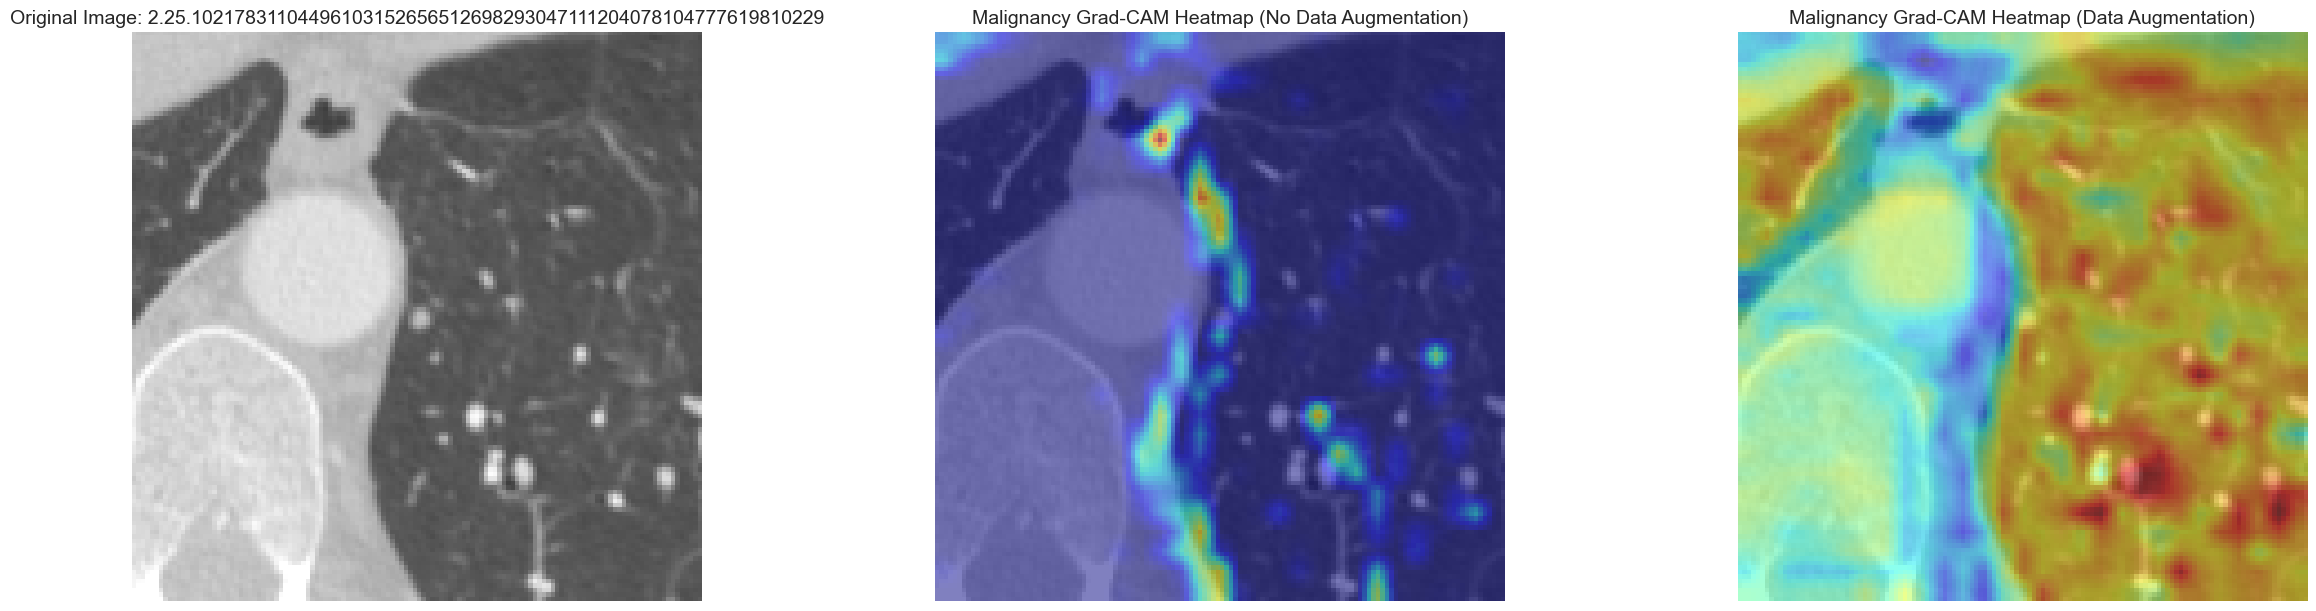

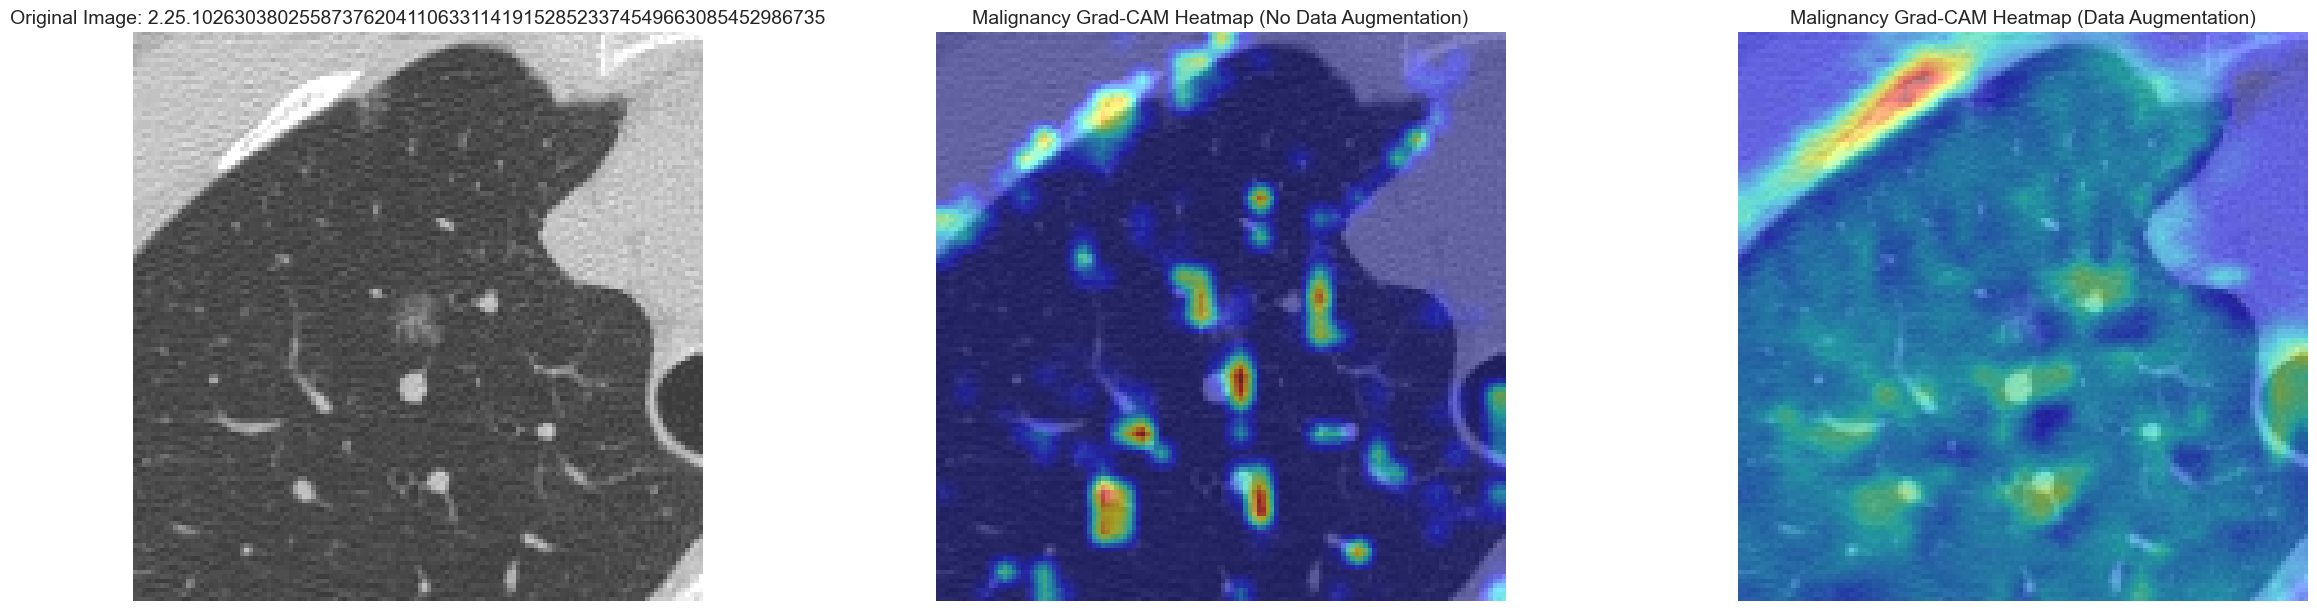

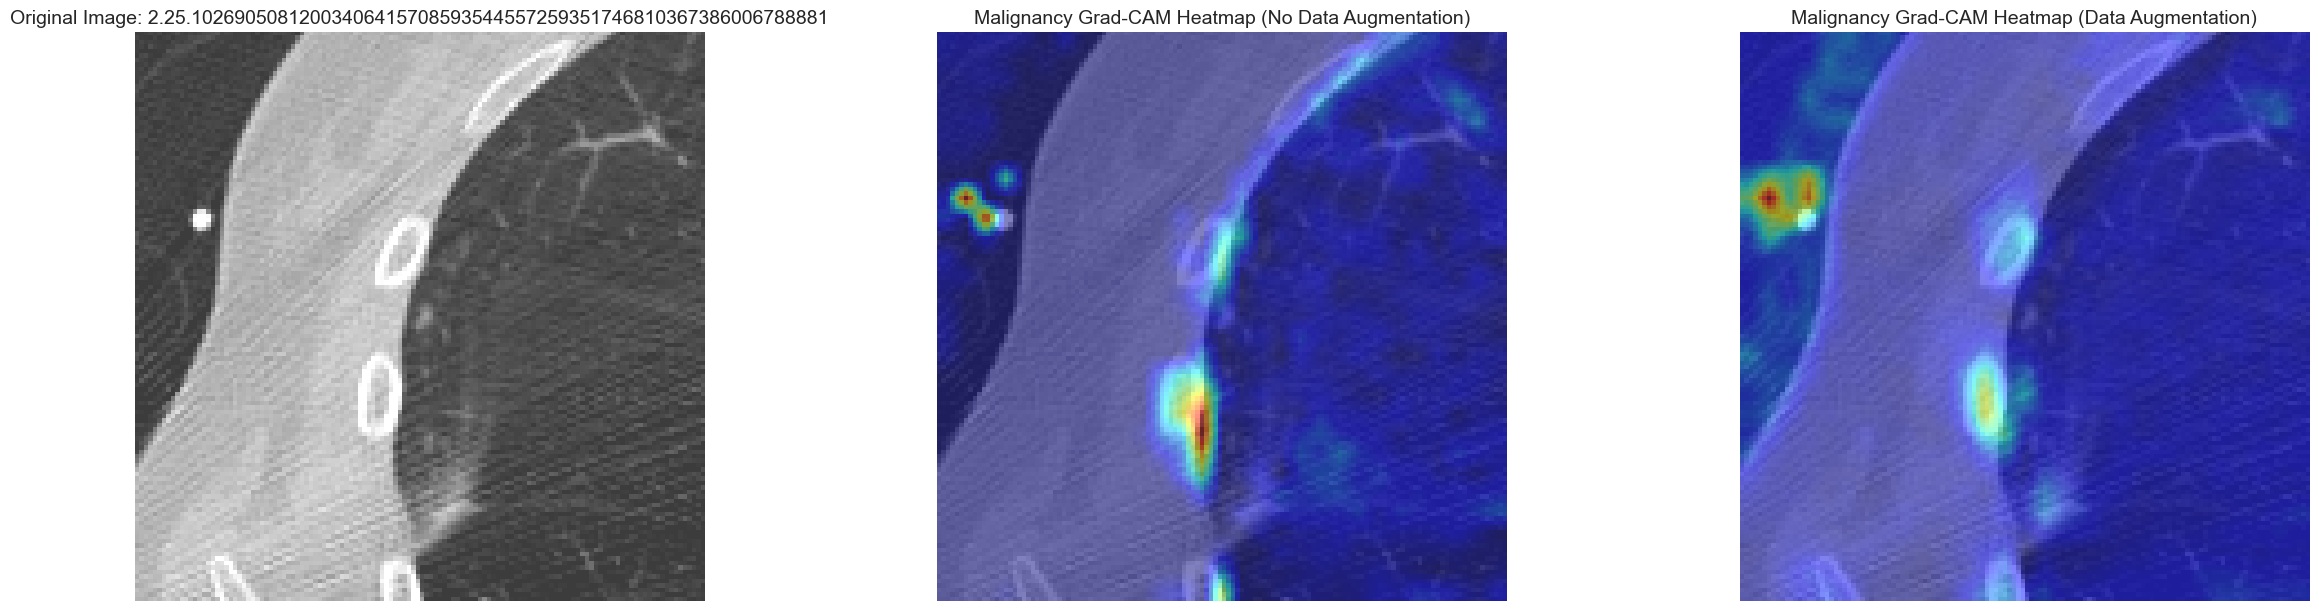

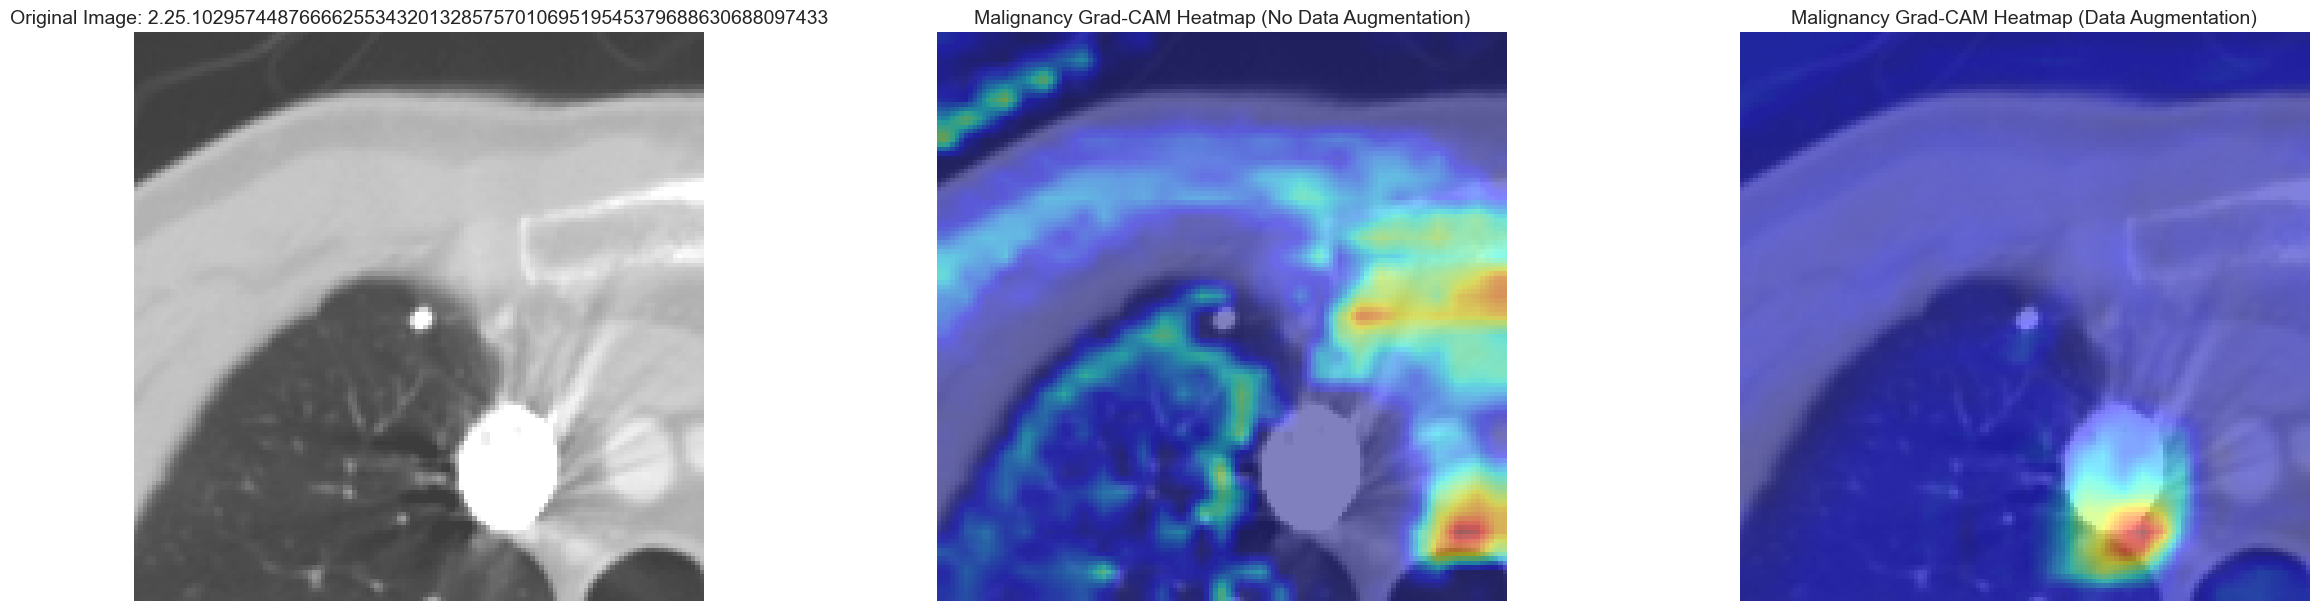

In [23]:
# Iterate over the test set images and create visualizations for original models and models trained with balanced dataset
for idx, image_path in enumerate(test_set_images_path.glob("*.mha")):
    noduleid = image_path.stem
    prediction = predictions[predictions.noduleid == noduleid].iloc[0]

    create_visualization_comparison_malignancy(image_path, prediction, idx, malignancy_model, malignancy_model_bal,
                                               malignancy_layer)

    if idx >= 9:  # Limit to 10 images for display
        break

### Grad-CAM Heatmaps Comparison for Nodule Type - Original and Balanced Models

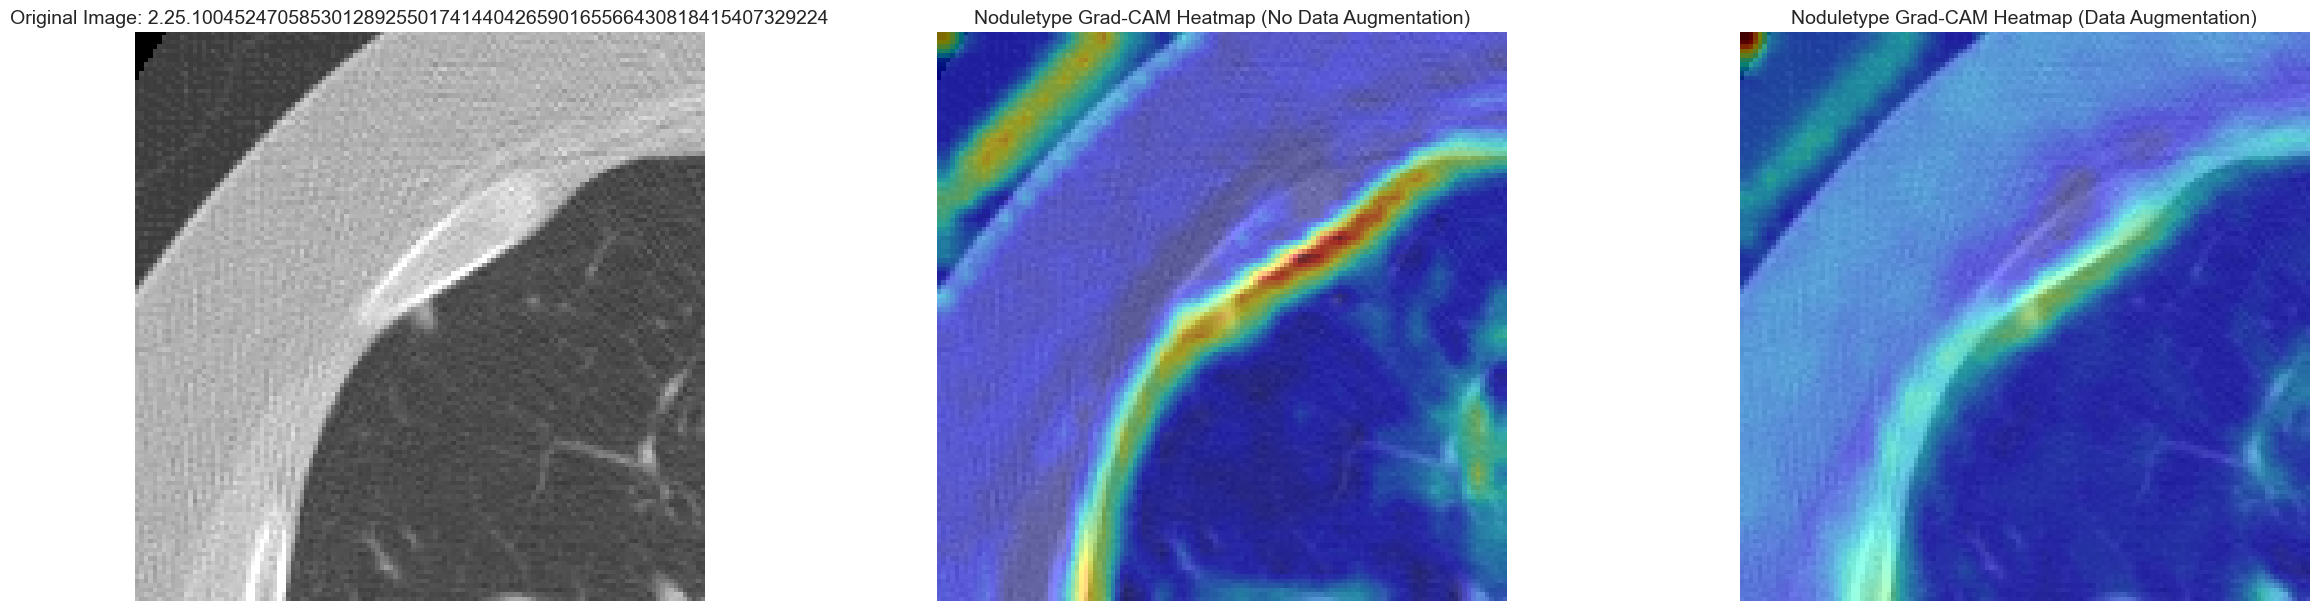

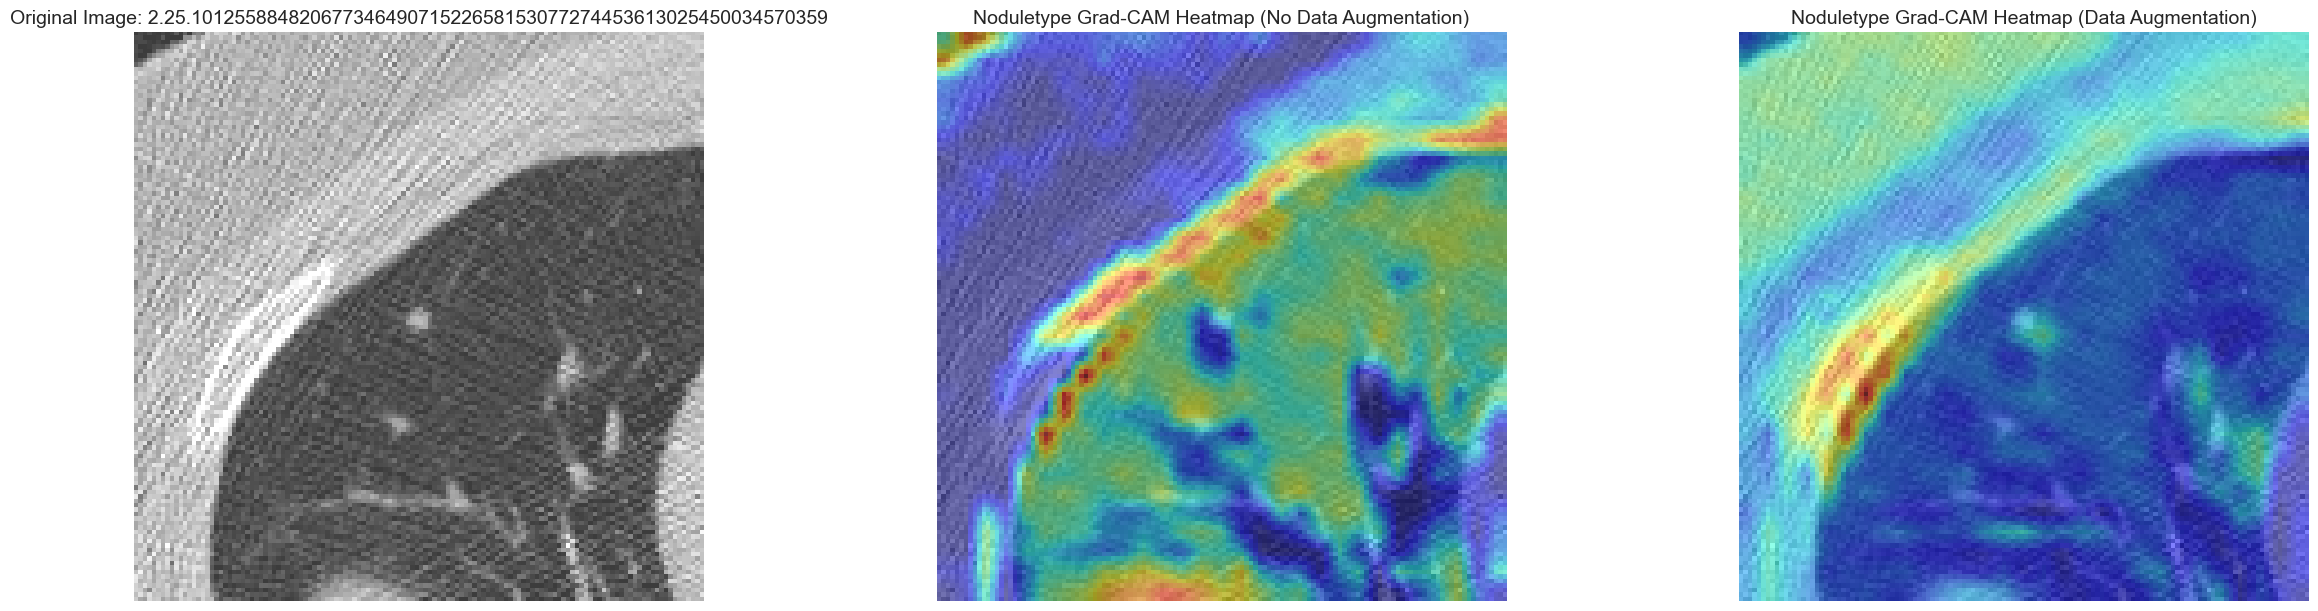

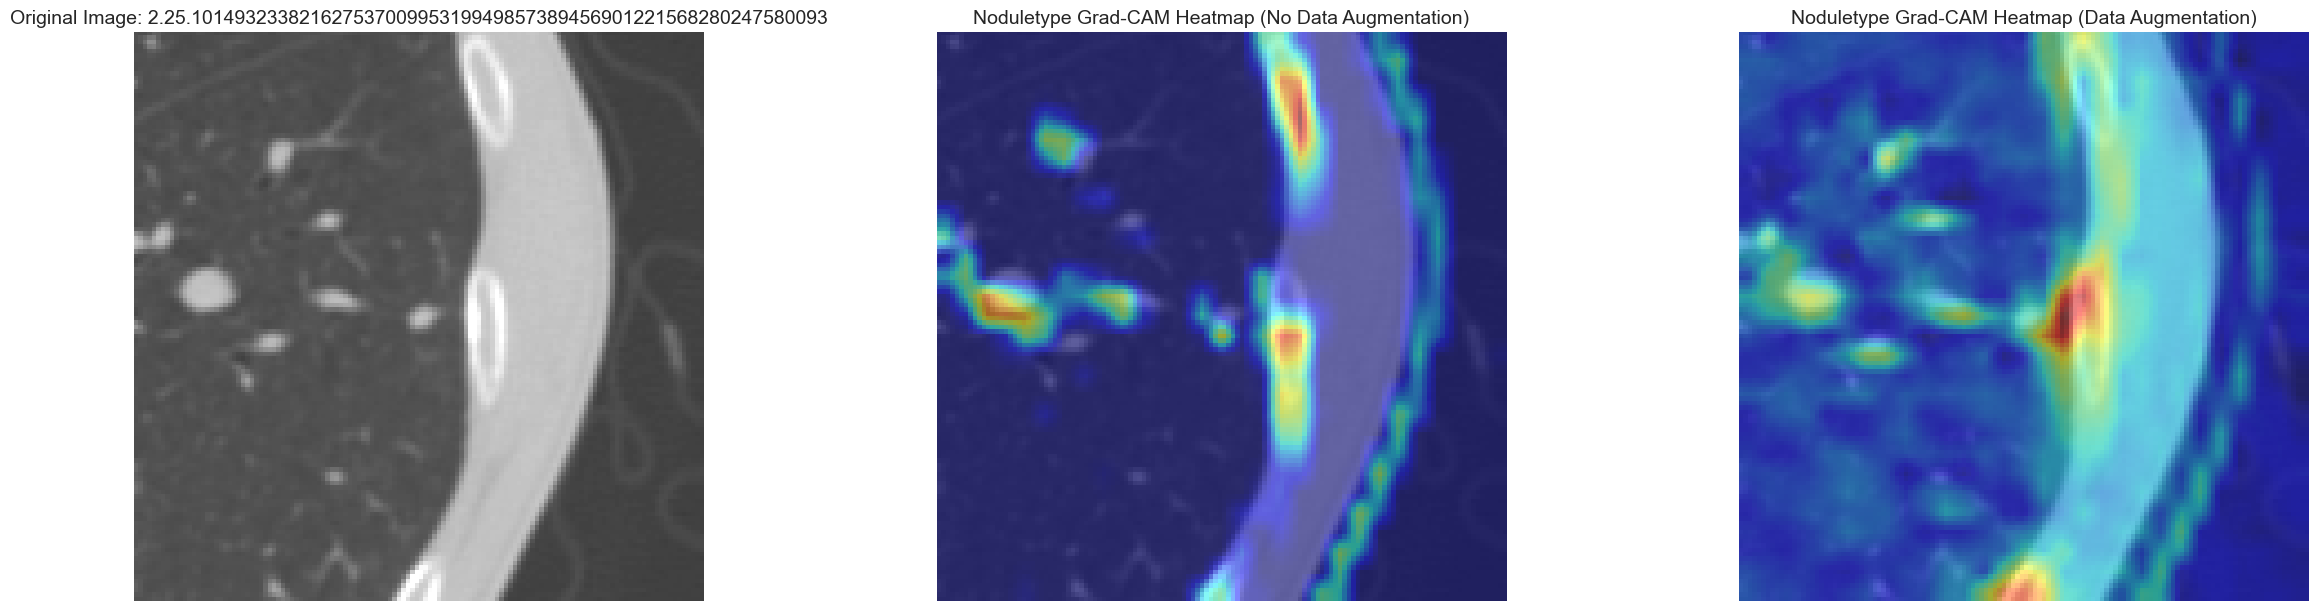

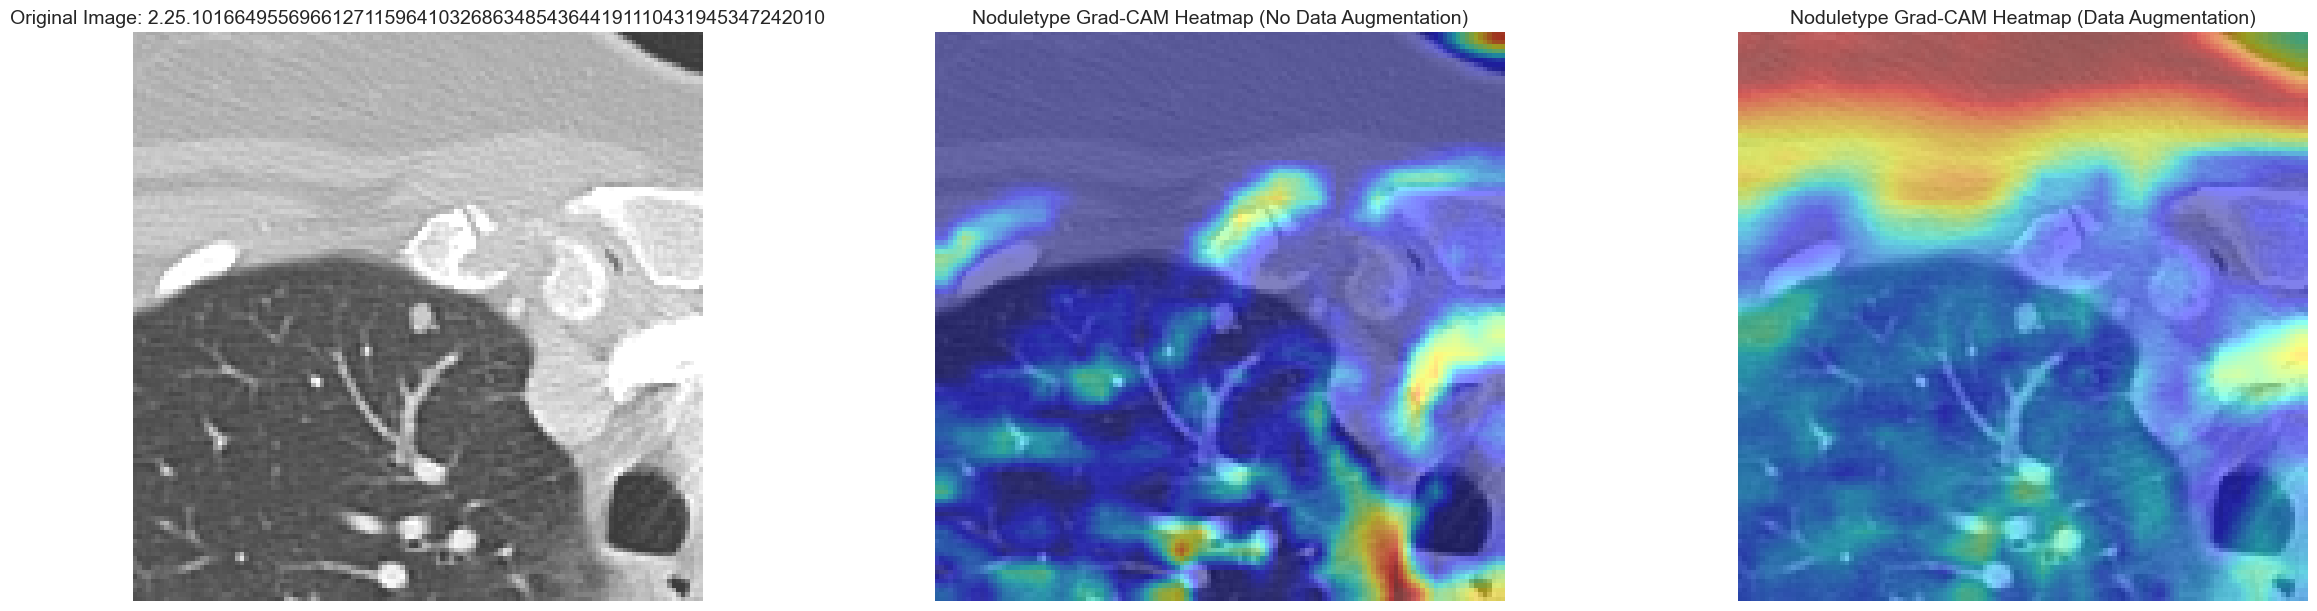

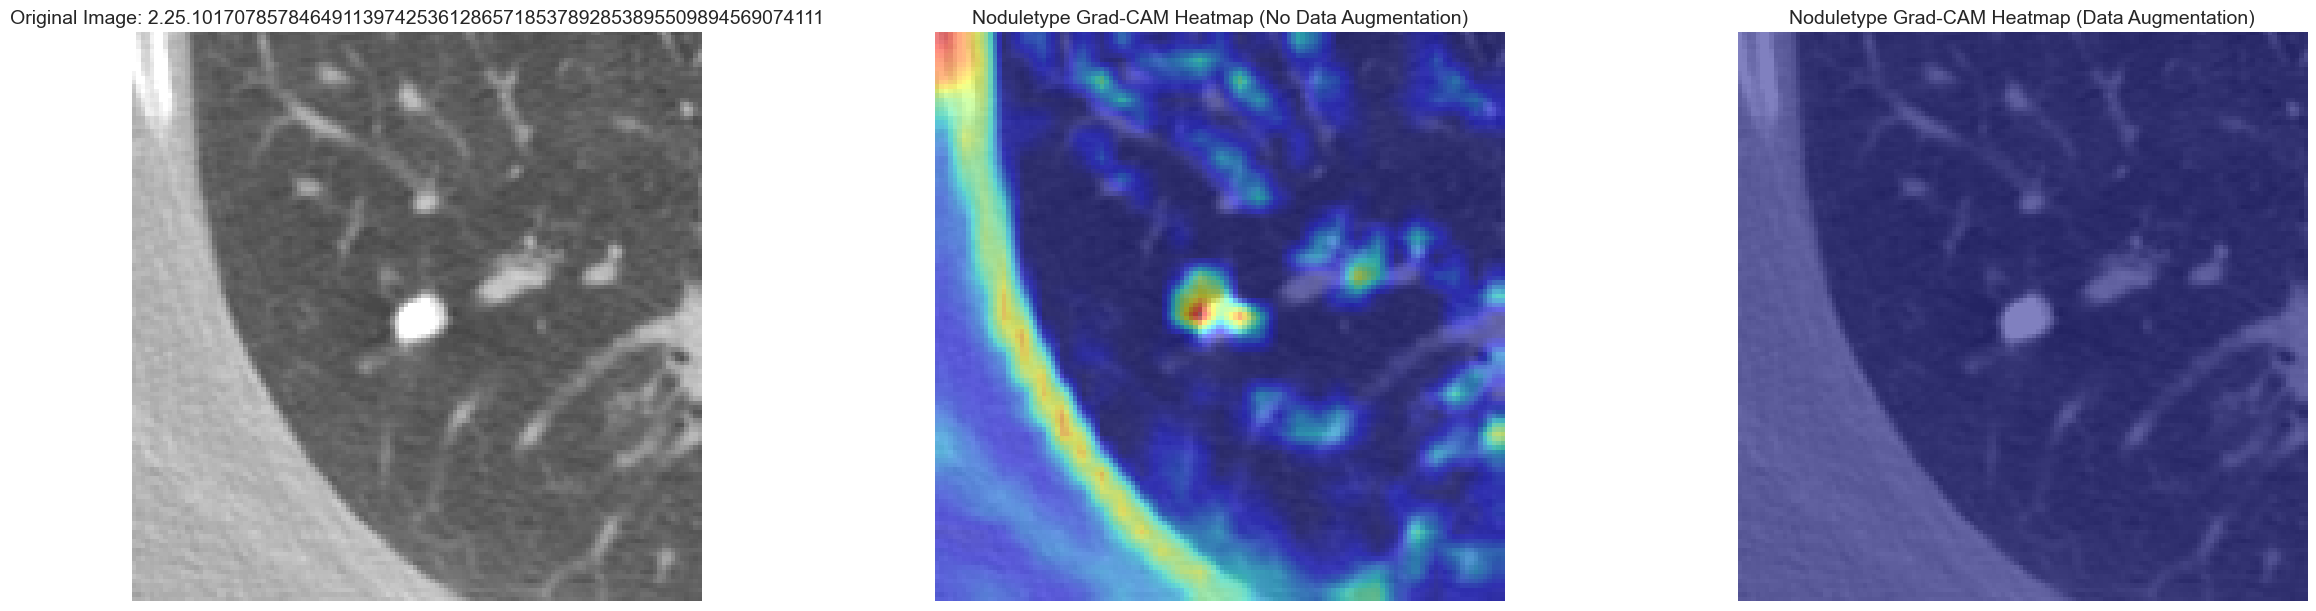

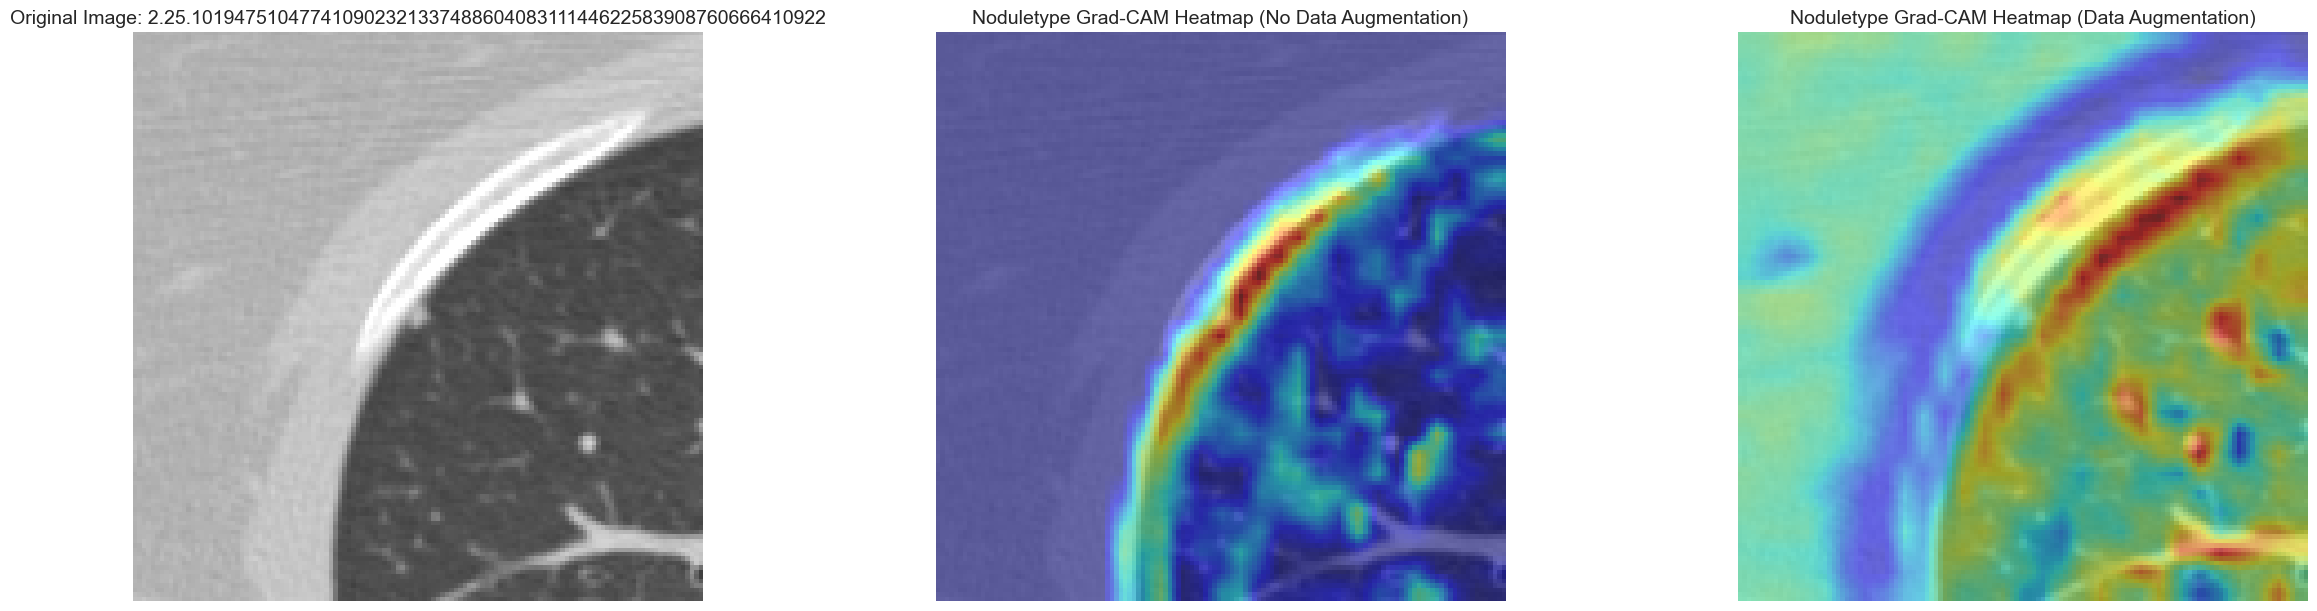

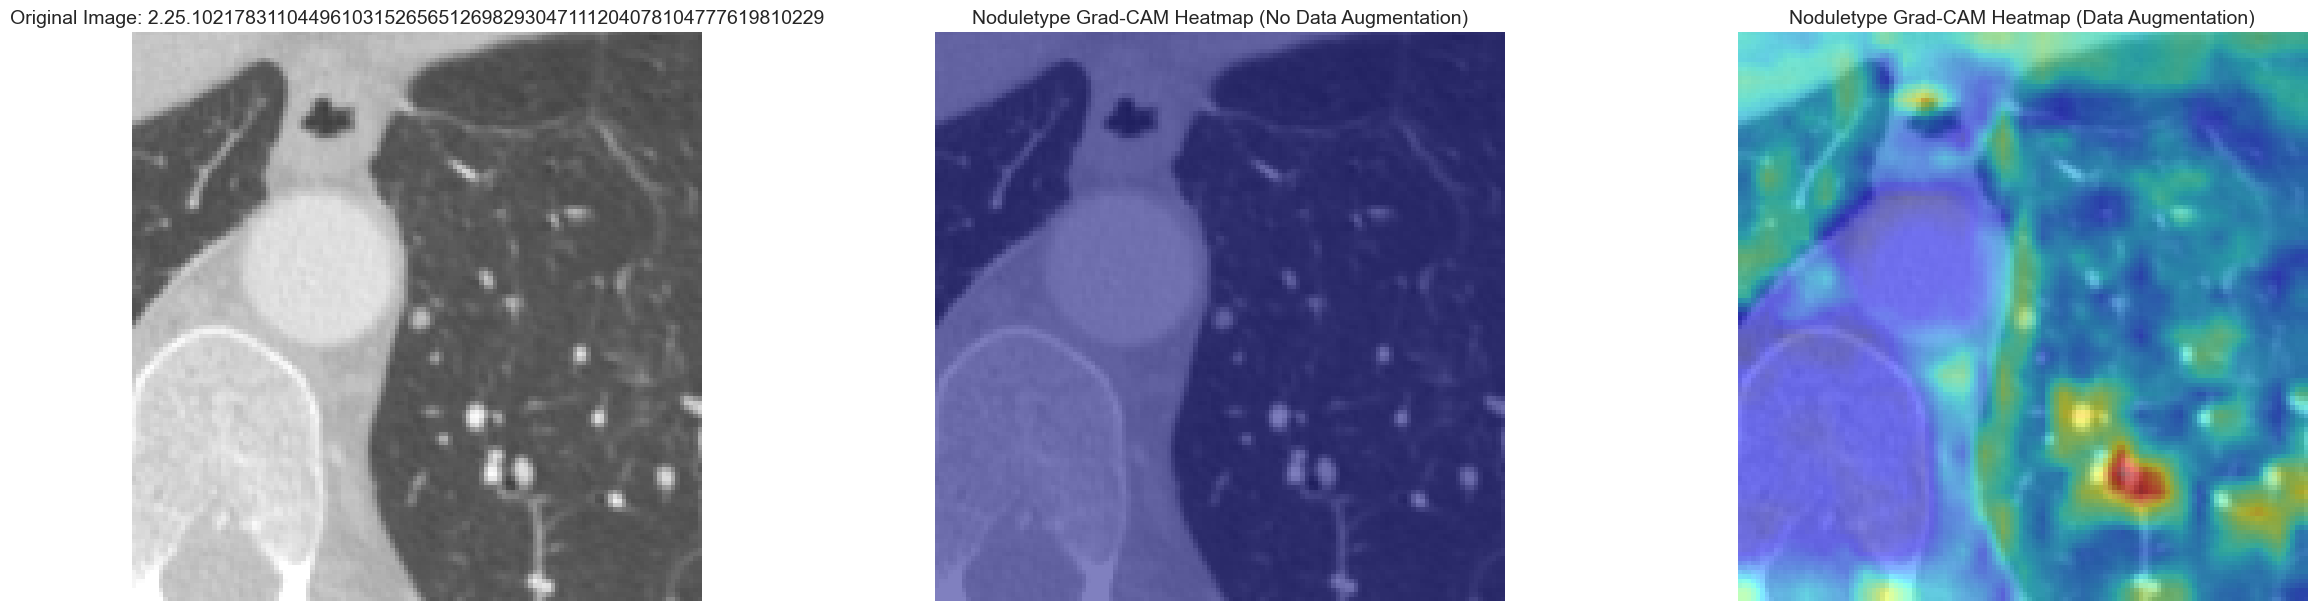

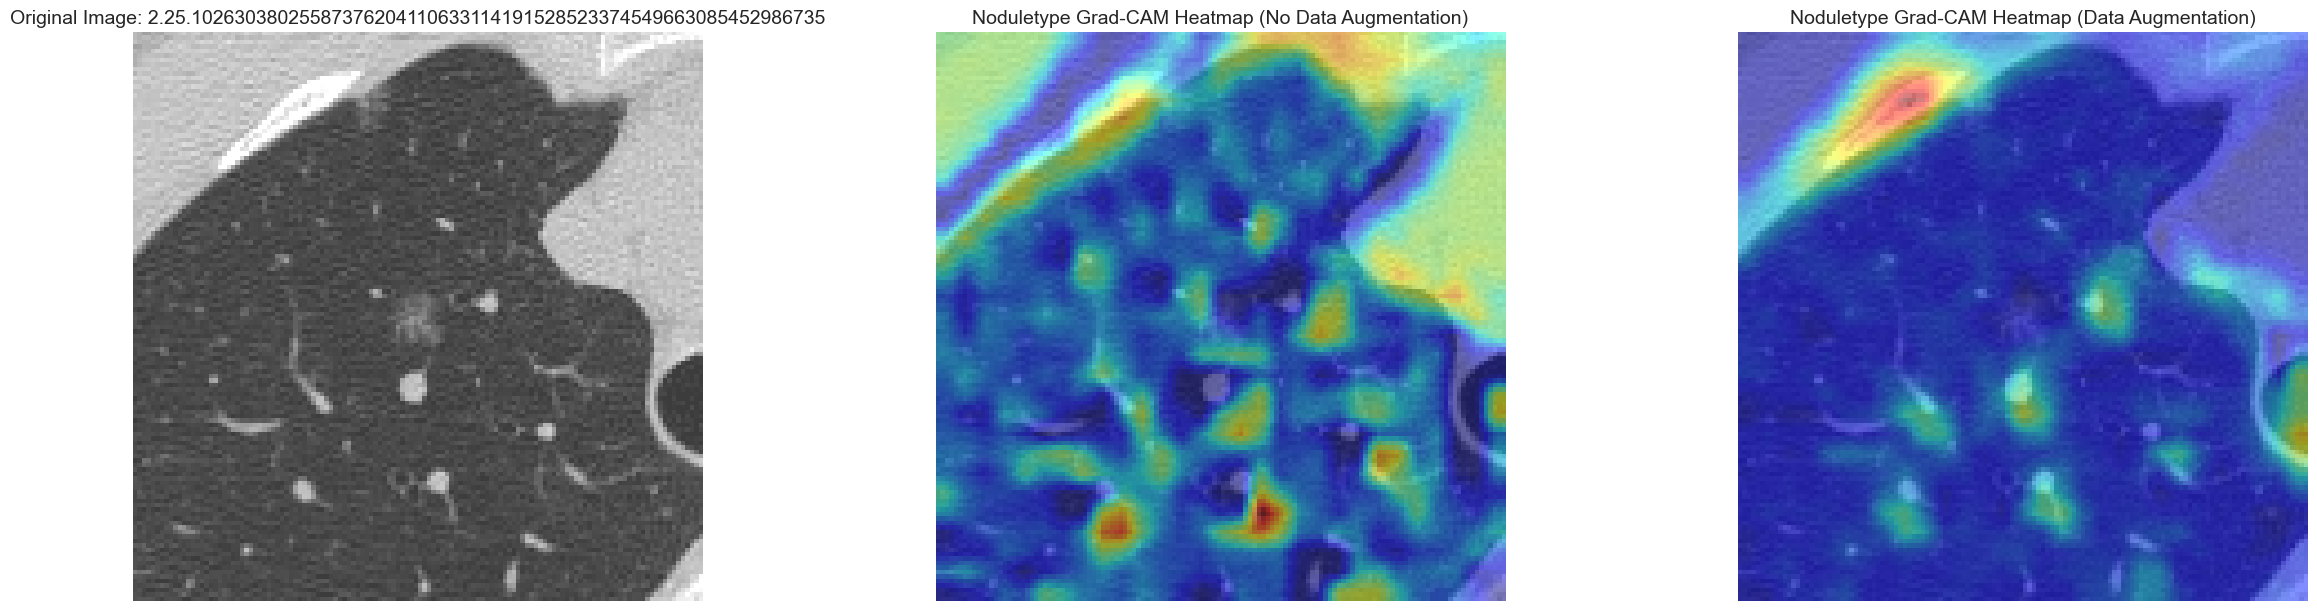

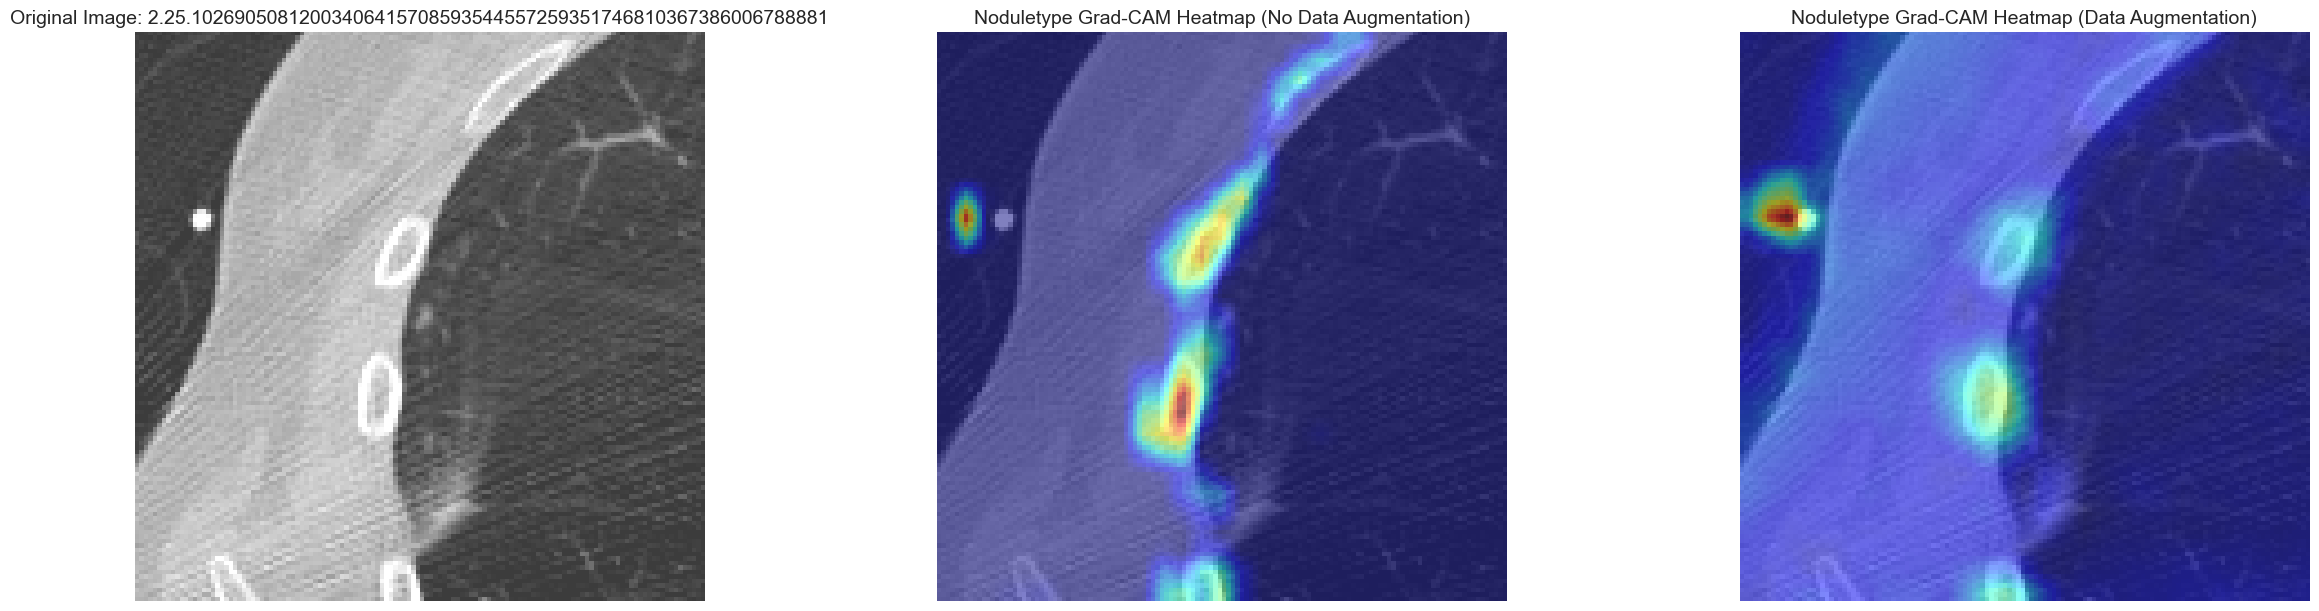

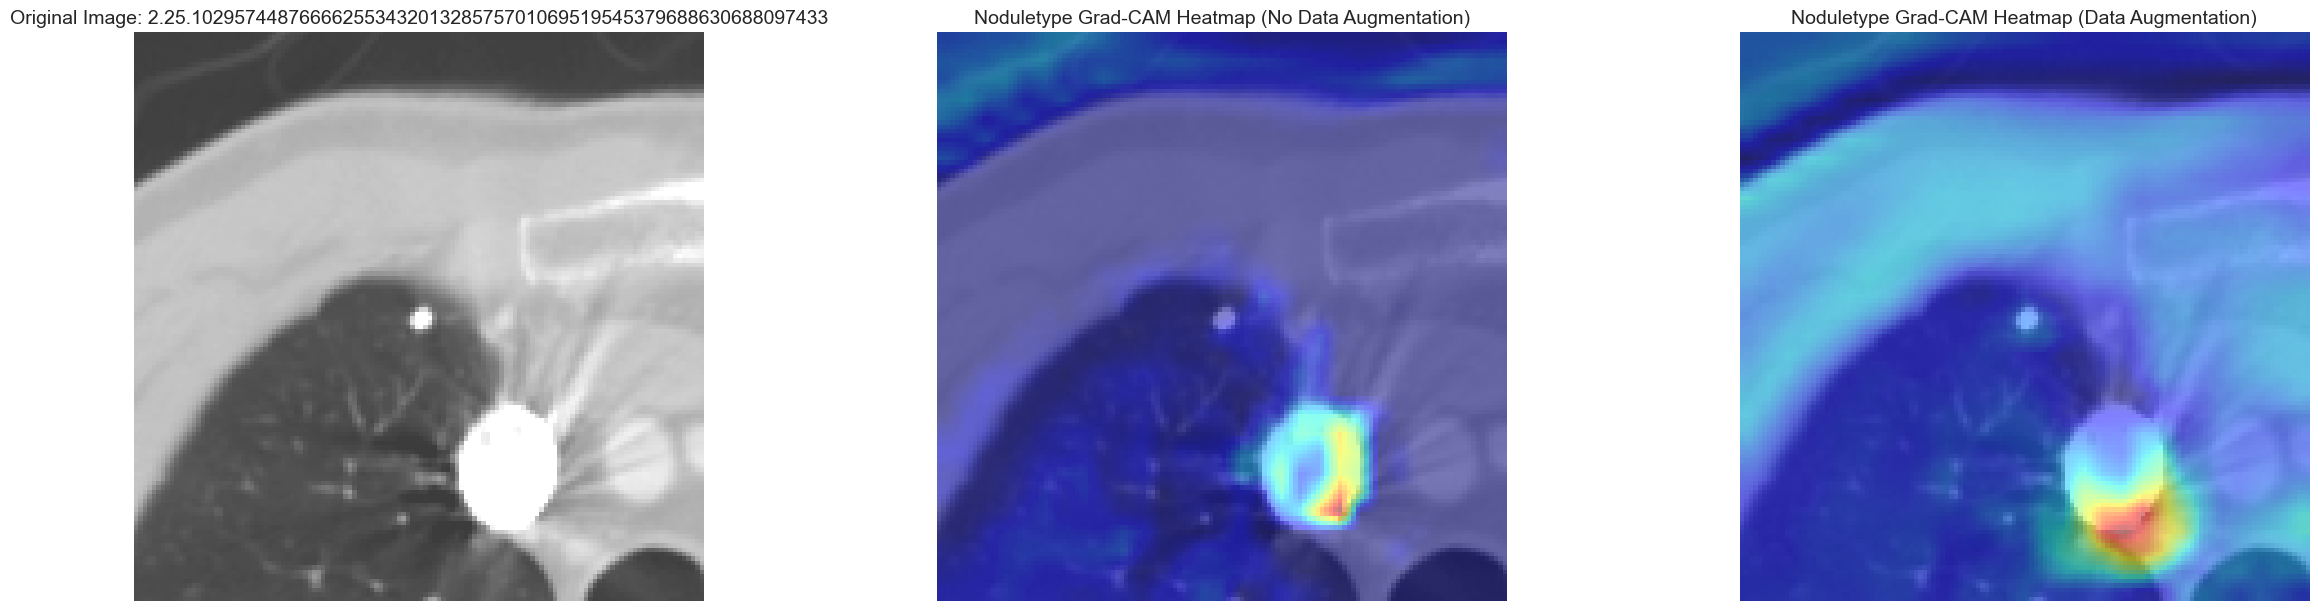

In [24]:
# Iterate over the test set images and create visualizations for original models and models trained with balanced dataset
for idx, image_path in enumerate(test_set_images_path.glob("*.mha")):
    noduleid = image_path.stem
    prediction = predictions[predictions.noduleid == noduleid].iloc[0]

    create_visualization_comparison_noduletype(image_path, prediction, idx, noduletype_model, noduletype_model_bal,
                                               noduletype_layer)

    if idx >= 9:  # Limit to 10 images for display
        break